已重启 env-zqh (Python 3.11.0)

In [ ]:
import torch
import torch.nn as nn
import numpy as np
from functorch import make_functional, vmap, jacrev
# from ucimlrepo import fetch_ucirepo 
import collections
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd


class Network(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size, depth, act=torch.nn.Sigmoid()):
        super(Network, self).__init__()
        layers = []
        layers.append(("layer1", nn.Linear(input_size, hidden_size1)))
        layers.append(("activation1", act))
        if depth >= 2:
            layers.append(("layer2", nn.Linear(hidden_size1, hidden_size2)))
            layers.append(("activation2", act))
            layers.append(("layer3", nn.Linear(hidden_size2, output_size, bias=False)))
        else:
            layers.append(("layer2", nn.Linear(hidden_size1, output_size, bias=False)))
        self.model = nn.Sequential(collections.OrderedDict(layers))
        self.p_number = sum(p.numel() for p in self.model.parameters())

    def forward(self, x):
        return self.model(x)

class PINN_LM:
    def __init__(self, X_data, y_data, cuda_num=7):
        self.device = torch.device(f"cuda:{cuda_num}" if torch.cuda.is_available() else "cpu")
        self.X_data = X_data.to(self.device)
        self.y_data = y_data.to(self.device).view(-1)
        self.data_num = self.X_data.shape[0]

        self.model = Network(self.X_data.shape[1], 70, 70, 1, 2).double().to(self.device)
        self.p_number = self.model.p_number
        torch.set_default_dtype(torch.float64)
        print('model # of parameters:', self.p_number)

        self.loss_record = np.zeros(100000)
        self.time_record = np.zeros(100000)
        self.loss_iter = 0
        self.time_iter = 0
        ## Initial weights
        def initialize_weights(self):
            for m in self.modules():
                if isinstance(m, nn.Linear):
                    nn.init.xavier_normal_(m.weight.data)
                    if m.bias is not None:
                        m.bias.data.zero_()
                        # m.bias.data.normal_(mean=0.0, std=1.0)

        initialize_weights(self.model)
        
    

    def f(self, params, input_data):
        a = 0
        for module in self.model.model.children():
            if isinstance(module, nn.Linear):
                in_f = module.weight.size(1)
                out_f = module.weight.size(0)
                w_size = in_f * out_f
                module.weight.data = params[a:a + w_size].reshape(out_f, in_f).clone()
                a += w_size
                if module.bias is not None:
                    module.bias.data = params[a:a + out_f].clone()
                    a += out_f
        return torch.vmap(self.model)(input_data)

    def fx_fun(self, params):
        preds = self.f(params, self.X_data).view(-1)
        return preds - self.y_data

    def F_fun(self, fx):
        return torch.mean(fx**2)

    def J_func(self, params):
        params.requires_grad_(True)
        func_model, func_params = make_functional(self.model)

        def fm(x, fp): return func_model(fp, x).squeeze()
        def floss(fp, x): return fm(x, fp)

        per_sample_grads = vmap(jacrev(floss), (None, 0))(func_params, self.X_data)
        
        cnt=0
                
        for g in per_sample_grads: 
            g = g.detach()
            J_d = g.reshape(len(g),-1) if cnt == 0 else torch.hstack([J_d,g.reshape(len(g),-1)])
            cnt = 1
        
        result= J_d.detach()
        return result

    def broyden_partial_update(self, J_prev, delta_r, delta_theta, indices):
        with torch.no_grad():
            J_sub = J_prev[:, indices]
            correction = torch.outer((delta_r - J_sub @ delta_theta), delta_theta) / (delta_theta.T @ delta_theta)
            J_new = J_prev.clone()
            J_new[:, indices] = J_sub + correction
        return J_new

    def MLM(self, opt_num=200, step=50,bd_tol=1,zone=1/2):
        p = torch.cat([p.view(-1) for p in self.model.parameters()]).to(self.device)
        J = self.J_func(p)
        mu = 10
        lmin, lmax = 1e-16, 1e100
        lambda_up, lambda_down = 4, 0.25
        yi, yi2 = 1e-10, 1e-10
        alpha = 1
        F_pnew = 1
        k, reject = 0, 0
        elapsed_time_ms=0
        selected_cols = np.random.choice(self.p_number, opt_num, replace=False)
        start_event = torch.cuda.Event(enable_timing=True)
        start_event.record()
        while k < step:
            end_event = torch.cuda.Event(enable_timing=True)
            k += 1
            fx = self.fx_fun(p)
            F_p = self.F_fun(fx)
            J_opt = J[:, selected_cols]
            A_opt =torch.matmul(J_opt.t(),J_opt)
            diag = torch.eye(A_opt.shape[0]).to(self.device)
            H = A_opt + mu * diag
            with torch.no_grad():
                    
                    gk=torch.matmul(J.t(),fx)
                    # gkF=torch.matmul(J_opt.t(),fx)
                    gkF=gk[selected_cols]
            try:              
                    h_lm = torch.linalg.solve(H, -gkF)      
                        
            except:
                    print('singular matrix')

            p_new = p.clone()
            p_new[selected_cols] += alpha * h_lm.view(-1)
            fx_new = self.fx_fun(p_new)
            F_pnew = self.F_fun(fx_new)
            o = F_p - F_pnew
            o_=torch.matmul(gkF.t(),h_lm)+1/2*torch.matmul(h_lm.t(),torch.matmul(A_opt,h_lm))+1/2*mu*torch.norm(h_lm, p=2)

            if o / o_ > yi and torch.norm(gkF)**2 > yi2 / mu:
                reject=0
                self.loss_record[self.loss_iter] = float(F_pnew.item())
                self.loss_iter += 1
                self.time_record[self.time_iter] = elapsed_time_ms/1000
                self.time_iter += 1
                print(f"[{k}] Accept | Loss = {F_p.item():.6f} -> {F_pnew.item():.6f} | parameter #: {opt_num}| time: {elapsed_time_ms}")
                p = p_new
                if reject >= bd_tol:
                    J = self.J_func(p)
                else:
                    J = self.broyden_partial_update(J, fx_new - fx, h_lm.view(-1), selected_cols)
                mu = max(mu * lambda_down, lmin)
                if k%5==0:
                    rho=1/(2*torch.norm(gk,p=2)**4 * mu**2)
                    if rho <=1 :
                        opt_num=int(np.round(self.p_number*torch.sqrt(1-rho).item()))
                        print("optnumber",opt_num)
                        #torch.sqrt(1-1/(2*torch.norm(gk,p=2)**4 * mu**2))
                    else:
                        print('zone')
                        opt_num=int(np.round(zone*self.p_number))
                        
                    selected_cols = np.random.choice(self.p_number, opt_num, replace=False)

            else:
                if reject >= bd_tol:
                    J = self.J_func(p)
                print(f"[{k}] Reject")
                reject += 1
                
                
                mu = min(mu * lambda_up, lmax)
                
            end_event.record()
            torch.cuda.synchronize()  # Wait for the events to be recorded!
            elapsed_time_ms = start_event.elapsed_time(end_event)

        print(f"Training finished. Final loss:{F_pnew.item()}, average time: {elapsed_time_ms/(1000*step)}")
        
        
        
        
        
        
        
        
    def LM(self, opt_num=200, step=50,bd_tol=1):
        p = torch.cat([p.view(-1) for p in self.model.parameters()]).to(self.device)
        J = self.J_func(p)
        mu = 10
        lmin, lmax = 1e-16, 1e100
        lambda_up, lambda_down = 4, 0.25
        yi, yi2 = 1e-10, 1e-10
        alpha = 1
        F_pnew = 1
        k, reject = 0, 0
        elapsed_time_ms=0
        selected_cols = np.random.choice(self.p_number, opt_num, replace=False)
        start_event = torch.cuda.Event(enable_timing=True)
        start_event.record()
        while k < step:
            end_event = torch.cuda.Event(enable_timing=True)
            k += 1
            fx = self.fx_fun(p)
            F_p = self.F_fun(fx)
            J_opt = J[:, selected_cols]
            A_opt =torch.matmul(J_opt.t(),J_opt)
            diag = torch.eye(A_opt.shape[0]).to(self.device)
            H = A_opt + mu * diag
            with torch.no_grad():
                    # gkF=torch.matmul(J_opt.t(),fx)
                    
                    gk=torch.matmul(J.t(),fx)
                    gkF=gk[selected_cols]
            try:              
                    h_lm = torch.linalg.solve(H, -gkF)      
                        
            except:
                    print('singular matrix')

            p_new = p.clone()
            p_new[selected_cols] += alpha * h_lm.view(-1)
            fx_new = self.fx_fun(p_new)
            F_pnew = self.F_fun(fx_new)
            o = F_p - F_pnew
            o_=torch.matmul(gkF.t(),h_lm)+1/2*torch.matmul(h_lm.t(),torch.matmul(A_opt,h_lm))+1/2*mu*torch.norm(h_lm, p=2)

            if o / o_ > yi and torch.norm(gkF)**2 > yi2 / mu:
                reject=0
                self.loss_record[self.loss_iter] = float(F_pnew.item())
                self.loss_iter += 1
                self.time_record[self.time_iter] = elapsed_time_ms/1000
                self.time_iter += 1
                print(f"[{k}] Accept | Loss = {F_p.item():.6f} -> {F_pnew.item():.6f} | parameter #: {opt_num}| time: {elapsed_time_ms}")
                p = p_new
                if reject >= bd_tol:
                    J = self.J_func(p)
                else:
                    J = self.broyden_partial_update(J, fx_new - fx, h_lm.view(-1), selected_cols)
                mu = max(mu * lambda_down, lmin)
                
            else:
                if reject >= bd_tol:
                    J = self.J_func(p)
                print(f"[{k}] Reject")
                reject += 1
                
                mu = min(mu * lambda_up, lmax)
            end_event.record()
            torch.cuda.synchronize()  # Wait for the events to be recorded!
            elapsed_time_ms = start_event.elapsed_time(end_event)

        print(f"Training finished. Final loss:{F_pnew.item()}, average time: {elapsed_time_ms/(1000*step)}")
def plot_loss_vs_time(loss1, time1, loss2, time2, label1="LM", label2="MLM"):
        loss1 = loss1[time1 != 0]
        time1 = time1[time1 != 0]
        loss2 = loss2[time2 != 0]
        time2 = time2[time2 != 0]

        plt.figure(figsize=(10, 6))
        plt.plot(time1, loss1, label=label1, linewidth=2)
        plt.plot(time2, loss2, label=label2, linestyle='--', linewidth=2)

        plt.xlabel("GPU Time (s)")
        plt.ylabel("Loss")
        plt.title("Loss vs GPU Time")
        plt.yscale("log")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
# === 训练入口 ===
if __name__ == "__main__":

    # 读取 Excel 文件
    df = pd.read_excel("/home/zhy/Zhou/lm/Ccs/Concrete_Data.xls")

    # 显示列名（确认目标列是哪一个）
    # print(df.columns)

    # 假设最后一列是目标变量（Strength）
    X = df.iloc[:, :-1]  # 所有列（除最后一列）为特征
    y = df.iloc[:, -1]   # 最后一列为目标

    scaler_X = StandardScaler()
    scaler_y = StandardScaler()

    X_scaled = scaler_X.fit_transform(X)
    y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))
    print(y_scaled)

    
    # X_tensor = torch.tensor(X.values, dtype=torch.float64)
    # y_tensor = torch.tensor(y.values.reshape(-1, 1), dtype=torch.float64)
    X_tensor = torch.tensor(X_scaled, dtype=torch.float64)
    y_tensor = torch.tensor(y_scaled, dtype=torch.float64)
    print(X_tensor.shape)

    # 训练 LM
    model_lm = PINN_LM(X_tensor, y_tensor)
    model_lm.LM(opt_num=5880, step=1400,bd_tol=0)

    # 训练 MLM
    model_mlm = PINN_LM(X_tensor, y_tensor)
    model_mlm.MLM(opt_num=5880, step=1400,bd_tol=0)

    # 绘图对比
    plot_loss_vs_time(
        model_lm.loss_record, model_lm.time_record,
        model_mlm.loss_record, model_mlm.time_record,
        label1="LM", label2="MLM"
    )

[[ 2.64519215]
 [ 1.5612771 ]
 [ 0.26660766]
 ...
 [-0.7259282 ]
 [-0.18264932]
 [-0.20461667]]
torch.Size([1030, 8])
model # of parameters: 5670


<ipython-input-1-f4c3efc6b50b>:83: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.make_functional` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.func.functional_call` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  func_model, func_params = make_functional(self.model)
<ipython-input-1-f4c3efc6b50b>:88: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.jacrev` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.func.jacrev` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  per_sample_grads = vmap(jacrev(floss), (None, 0))(func_params, self.X_data)
<ipython

ValueError: Cannot take a larger sample than population when 'replace=False'

In [ ]:
import torch
import torch.nn as nn
import numpy as np
from functorch import make_functional, vmap, jacrev
# from ucimlrepo import fetch_ucirepo 
import collections
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd


class Network(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size, depth, act=torch.nn.Sigmoid()):
        super(Network, self).__init__()
        layers = []
        layers.append(("layer1", nn.Linear(input_size, hidden_size1)))
        layers.append(("activation1", act))
        if depth >= 2:
            layers.append(("layer2", nn.Linear(hidden_size1, hidden_size2)))
            layers.append(("activation2", act))
            layers.append(("layer3", nn.Linear(hidden_size2, output_size, bias=False)))
        else:
            layers.append(("layer2", nn.Linear(hidden_size1, output_size, bias=False)))
        self.model = nn.Sequential(collections.OrderedDict(layers))
        self.p_number = sum(p.numel() for p in self.model.parameters())

    def forward(self, x):
        return self.model(x)

class PINN_LM:
    def __init__(self, X_data, y_data, cuda_num=7):
        self.device = torch.device(f"cuda:{cuda_num}" if torch.cuda.is_available() else "cpu")
        self.X_data = X_data.to(self.device)
        self.y_data = y_data.to(self.device).view(-1)
        self.data_num = self.X_data.shape[0]

        self.model = Network(self.X_data.shape[1], 70, 70, 1, 2).double().to(self.device)
        self.p_number = self.model.p_number
        torch.set_default_dtype(torch.float64)
        print('model # of parameters:', self.p_number)

        self.loss_record = np.zeros(100000)
        self.time_record = np.zeros(100000)
        self.loss_iter = 0
        self.time_iter = 0
        ## Initial weights
        def initialize_weights(self):
            for m in self.modules():
                if isinstance(m, nn.Linear):
                    nn.init.xavier_normal_(m.weight.data)
                    if m.bias is not None:
                        m.bias.data.zero_()
                        # m.bias.data.normal_(mean=0.0, std=1.0)

        initialize_weights(self.model)
        
    

    def f(self, params, input_data):
        a = 0
        for module in self.model.model.children():
            if isinstance(module, nn.Linear):
                in_f = module.weight.size(1)
                out_f = module.weight.size(0)
                w_size = in_f * out_f
                module.weight.data = params[a:a + w_size].reshape(out_f, in_f).clone()
                a += w_size
                if module.bias is not None:
                    module.bias.data = params[a:a + out_f].clone()
                    a += out_f
        return torch.vmap(self.model)(input_data)

    def fx_fun(self, params):
        preds = self.f(params, self.X_data).view(-1)
        return preds - self.y_data

    def F_fun(self, fx):
        return torch.mean(fx**2)

    def J_func(self, params):
        params.requires_grad_(True)
        func_model, func_params = make_functional(self.model)

        def fm(x, fp): return func_model(fp, x).squeeze()
        def floss(fp, x): return fm(x, fp)

        per_sample_grads = vmap(jacrev(floss), (None, 0))(func_params, self.X_data)
        
        cnt=0
                
        for g in per_sample_grads: 
            g = g.detach()
            J_d = g.reshape(len(g),-1) if cnt == 0 else torch.hstack([J_d,g.reshape(len(g),-1)])
            cnt = 1
        
        result= J_d.detach()
        return result

    def broyden_partial_update(self, J_prev, delta_r, delta_theta, indices):
        with torch.no_grad():
            J_sub = J_prev[:, indices]
            correction = torch.outer((delta_r - J_sub @ delta_theta), delta_theta) / (delta_theta.T @ delta_theta)
            J_new = J_prev.clone()
            J_new[:, indices] = J_sub + correction
        return J_new

    def MLM(self, opt_num=200, step=50,bd_tol=1,zone=1/2):
        p = torch.cat([p.view(-1) for p in self.model.parameters()]).to(self.device)
        J = self.J_func(p)
        mu = 10
        lmin, lmax = 1e-16, 1e100
        lambda_up, lambda_down = 4, 0.25
        yi, yi2 = 1e-10, 1e-10
        alpha = 1
        F_pnew = 1
        k, reject = 0, 0
        elapsed_time_ms=0
        selected_cols = np.random.choice(self.p_number, opt_num, replace=False)
        start_event = torch.cuda.Event(enable_timing=True)
        start_event.record()
        while k < step:
            end_event = torch.cuda.Event(enable_timing=True)
            k += 1
            fx = self.fx_fun(p)
            F_p = self.F_fun(fx)
            J_opt = J[:, selected_cols]
            A_opt =torch.matmul(J_opt.t(),J_opt)
            diag = torch.eye(A_opt.shape[0]).to(self.device)
            H = A_opt + mu * diag
            with torch.no_grad():
                    
                    gk=torch.matmul(J.t(),fx)
                    # gkF=torch.matmul(J_opt.t(),fx)
                    gkF=gk[selected_cols]
            try:              
                    h_lm = torch.linalg.solve(H, -gkF)      
                        
            except:
                    print('singular matrix')

            p_new = p.clone()
            p_new[selected_cols] += alpha * h_lm.view(-1)
            fx_new = self.fx_fun(p_new)
            F_pnew = self.F_fun(fx_new)
            o = F_p - F_pnew
            o_=torch.matmul(gkF.t(),h_lm)+1/2*torch.matmul(h_lm.t(),torch.matmul(A_opt,h_lm))+1/2*mu*torch.norm(h_lm, p=2)

            if o / o_ > yi and torch.norm(gkF)**2 > yi2 / mu:
                reject=0
                self.loss_record[self.loss_iter] = float(F_pnew.item())
                self.loss_iter += 1
                self.time_record[self.time_iter] = elapsed_time_ms/1000
                self.time_iter += 1
                print(f"[{k}] Accept | Loss = {F_p.item():.6f} -> {F_pnew.item():.6f} | parameter #: {opt_num}| time: {elapsed_time_ms}")
                p = p_new
                if reject >= bd_tol:
                    J = self.J_func(p)
                else:
                    J = self.broyden_partial_update(J, fx_new - fx, h_lm.view(-1), selected_cols)
                mu = max(mu * lambda_down, lmin)
                if k%5==0:
                    rho=1/(2*torch.norm(gk,p=2)**4 * mu**2)
                    if rho <=1 :
                        opt_num=int(np.round(self.p_number*torch.sqrt(1-rho).item()))
                        print("optnumber",opt_num)
                        #torch.sqrt(1-1/(2*torch.norm(gk,p=2)**4 * mu**2))
                    else:
                        print('zone')
                        opt_num=int(np.round(zone*self.p_number))
                        
                    selected_cols = np.random.choice(self.p_number, opt_num, replace=False)

            else:
                if reject >= bd_tol:
                    J = self.J_func(p)
                print(f"[{k}] Reject")
                reject += 1
                
                
                mu = min(mu * lambda_up, lmax)
                
            end_event.record()
            torch.cuda.synchronize()  # Wait for the events to be recorded!
            elapsed_time_ms = start_event.elapsed_time(end_event)

        print(f"Training finished. Final loss:{F_pnew.item()}, average time: {elapsed_time_ms/(1000*step)}")
        
        
        
        
        
        
        
        
    def LM(self, opt_num=200, step=50,bd_tol=1):
        p = torch.cat([p.view(-1) for p in self.model.parameters()]).to(self.device)
        J = self.J_func(p)
        mu = 10
        lmin, lmax = 1e-16, 1e100
        lambda_up, lambda_down = 4, 0.25
        yi, yi2 = 1e-10, 1e-10
        alpha = 1
        F_pnew = 1
        k, reject = 0, 0
        elapsed_time_ms=0
        selected_cols = np.random.choice(self.p_number, opt_num, replace=False)
        start_event = torch.cuda.Event(enable_timing=True)
        start_event.record()
        while k < step:
            end_event = torch.cuda.Event(enable_timing=True)
            k += 1
            fx = self.fx_fun(p)
            F_p = self.F_fun(fx)
            J_opt = J[:, selected_cols]
            A_opt =torch.matmul(J_opt.t(),J_opt)
            diag = torch.eye(A_opt.shape[0]).to(self.device)
            H = A_opt + mu * diag
            with torch.no_grad():
                    # gkF=torch.matmul(J_opt.t(),fx)
                    
                    gk=torch.matmul(J.t(),fx)
                    gkF=gk[selected_cols]
            try:              
                    h_lm = torch.linalg.solve(H, -gkF)      
                        
            except:
                    print('singular matrix')

            p_new = p.clone()
            p_new[selected_cols] += alpha * h_lm.view(-1)
            fx_new = self.fx_fun(p_new)
            F_pnew = self.F_fun(fx_new)
            o = F_p - F_pnew
            o_=torch.matmul(gkF.t(),h_lm)+1/2*torch.matmul(h_lm.t(),torch.matmul(A_opt,h_lm))+1/2*mu*torch.norm(h_lm, p=2)

            if o / o_ > yi and torch.norm(gkF)**2 > yi2 / mu:
                reject=0
                self.loss_record[self.loss_iter] = float(F_pnew.item())
                self.loss_iter += 1
                self.time_record[self.time_iter] = elapsed_time_ms/1000
                self.time_iter += 1
                print(f"[{k}] Accept | Loss = {F_p.item():.6f} -> {F_pnew.item():.6f} | parameter #: {opt_num}| time: {elapsed_time_ms}")
                p = p_new
                if reject >= bd_tol:
                    J = self.J_func(p)
                else:
                    J = self.broyden_partial_update(J, fx_new - fx, h_lm.view(-1), selected_cols)
                mu = max(mu * lambda_down, lmin)
                
            else:
                if reject >= bd_tol:
                    J = self.J_func(p)
                print(f"[{k}] Reject")
                reject += 1
                
                mu = min(mu * lambda_up, lmax)
            end_event.record()
            torch.cuda.synchronize()  # Wait for the events to be recorded!
            elapsed_time_ms = start_event.elapsed_time(end_event)

        print(f"Training finished. Final loss:{F_pnew.item()}, average time: {elapsed_time_ms/(1000*step)}")
def plot_loss_vs_time(loss1, time1, loss2, time2, label1="LM", label2="MLM"):
        loss1 = loss1[time1 != 0]
        time1 = time1[time1 != 0]
        loss2 = loss2[time2 != 0]
        time2 = time2[time2 != 0]

        plt.figure(figsize=(10, 6))
        plt.plot(time1, loss1, label=label1, linewidth=2)
        plt.plot(time2, loss2, label=label2, linestyle='--', linewidth=2)

        plt.xlabel("GPU Time (s)")
        plt.ylabel("Loss")
        plt.title("Loss vs GPU Time")
        plt.yscale("log")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
# === 训练入口 ===
if __name__ == "__main__":

    # 读取 Excel 文件
    df = pd.read_excel("/home/zhy/Zhou/lm/Ccs/Concrete_Data.xls")

    # 显示列名（确认目标列是哪一个）
    # print(df.columns)

    # 假设最后一列是目标变量（Strength）
    X = df.iloc[:, :-1]  # 所有列（除最后一列）为特征
    y = df.iloc[:, -1]   # 最后一列为目标

    scaler_X = StandardScaler()
    scaler_y = StandardScaler()

    X_scaled = scaler_X.fit_transform(X)
    y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))
    print(y_scaled)

    
    # X_tensor = torch.tensor(X.values, dtype=torch.float64)
    # y_tensor = torch.tensor(y.values.reshape(-1, 1), dtype=torch.float64)
    X_tensor = torch.tensor(X_scaled, dtype=torch.float64)
    y_tensor = torch.tensor(y_scaled, dtype=torch.float64)
    print(X_tensor.shape)

    # 训练 LM
    model_lm = PINN_LM(X_tensor, y_tensor)
    model_lm.LM(opt_num=5880, step=1400,bd_tol=0)

    # 训练 MLM
    model_mlm = PINN_LM(X_tensor, y_tensor)
    model_mlm.MLM(opt_num=5880, step=1400,bd_tol=0)

    # 绘图对比
    plot_loss_vs_time(
        model_lm.loss_record, model_lm.time_record,
        model_mlm.loss_record, model_mlm.time_record,
        label1="LM", label2="MLM"
    )

[[ 2.64519215]
 [ 1.5612771 ]
 [ 0.26660766]
 ...
 [-0.7259282 ]
 [-0.18264932]
 [-0.20461667]]
torch.Size([1030, 8])
model # of parameters: 5670


<ipython-input-2-f4c3efc6b50b>:83: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.make_functional` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.func.functional_call` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  func_model, func_params = make_functional(self.model)
<ipython-input-2-f4c3efc6b50b>:88: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.jacrev` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.func.jacrev` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  per_sample_grads = vmap(jacrev(floss), (None, 0))(func_params, self.X_data)
<ipython

ValueError: Cannot take a larger sample than population when 'replace=False'

[[ 2.64519215]
 [ 1.5612771 ]
 [ 0.26660766]
 ...
 [-0.7259282 ]
 [-0.18264932]
 [-0.20461667]]
torch.Size([1030, 8])
model # of parameters: 5670


<ipython-input-3-2d718767bfa5>:83: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.make_functional` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.func.functional_call` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  func_model, func_params = make_functional(self.model)
<ipython-input-3-2d718767bfa5>:88: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.jacrev` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.func.jacrev` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  per_sample_grads = vmap(jacrev(floss), (None, 0))(func_params, self.X_data)
<ipython

[1] Reject
[2] Reject
[3] Reject
[4] Accept | Loss = 1.043911 -> 0.944329 | parameter #: 5670| time: 492.7088623046875
[5] Reject
[6] Accept | Loss = 0.944329 -> 0.881152 | parameter #: 5670| time: 732.948486328125
[7] Reject
[8] Accept | Loss = 0.881152 -> 0.803187 | parameter #: 5670| time: 1004.3975830078125
[9] Reject
[10] Accept | Loss = 0.803187 -> 0.715545 | parameter #: 5670| time: 1258.29736328125
[11] Reject
[12] Accept | Loss = 0.715545 -> 0.628794 | parameter #: 5670| time: 1516.205078125
[13] Reject
[14] Accept | Loss = 0.628794 -> 0.553885 | parameter #: 5670| time: 1797.93505859375
[15] Reject
[16] Accept | Loss = 0.553885 -> 0.496812 | parameter #: 5670| time: 2064.064453125
[17] Reject
[18] Accept | Loss = 0.496812 -> 0.457462 | parameter #: 5670| time: 2329.460693359375
[19] Accept | Loss = 0.457462 -> 0.406373 | parameter #: 5670| time: 2462.762939453125
[20] Reject
[21] Accept | Loss = 0.406373 -> 0.386867 | parameter #: 5670| time: 2720.73828125
[22] Reject
[23] Ac

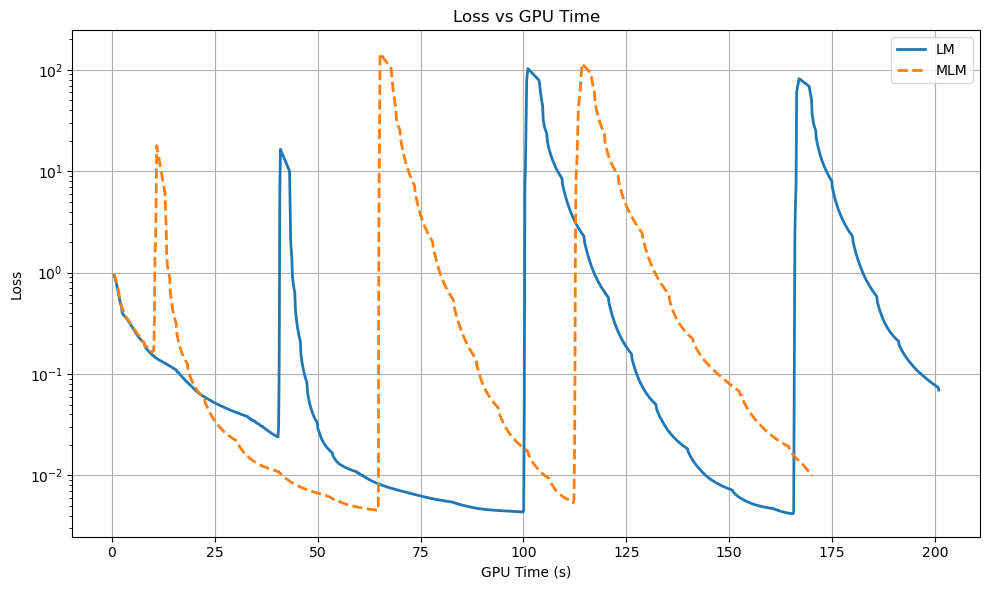

In [ ]:
import torch
import torch.nn as nn
import numpy as np
from functorch import make_functional, vmap, jacrev
# from ucimlrepo import fetch_ucirepo 
import collections
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd


class Network(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size, depth, act=torch.nn.Sigmoid()):
        super(Network, self).__init__()
        layers = []
        layers.append(("layer1", nn.Linear(input_size, hidden_size1)))
        layers.append(("activation1", act))
        if depth >= 2:
            layers.append(("layer2", nn.Linear(hidden_size1, hidden_size2)))
            layers.append(("activation2", act))
            layers.append(("layer3", nn.Linear(hidden_size2, output_size, bias=False)))
        else:
            layers.append(("layer2", nn.Linear(hidden_size1, output_size, bias=False)))
        self.model = nn.Sequential(collections.OrderedDict(layers))
        self.p_number = sum(p.numel() for p in self.model.parameters())

    def forward(self, x):
        return self.model(x)

class PINN_LM:
    def __init__(self, X_data, y_data, cuda_num=7):
        self.device = torch.device(f"cuda:{cuda_num}" if torch.cuda.is_available() else "cpu")
        self.X_data = X_data.to(self.device)
        self.y_data = y_data.to(self.device).view(-1)
        self.data_num = self.X_data.shape[0]

        self.model = Network(self.X_data.shape[1], 70, 70, 1, 2).double().to(self.device)
        self.p_number = self.model.p_number
        torch.set_default_dtype(torch.float64)
        print('model # of parameters:', self.p_number)

        self.loss_record = np.zeros(100000)
        self.time_record = np.zeros(100000)
        self.loss_iter = 0
        self.time_iter = 0
        ## Initial weights
        def initialize_weights(self):
            for m in self.modules():
                if isinstance(m, nn.Linear):
                    nn.init.xavier_normal_(m.weight.data)
                    if m.bias is not None:
                        m.bias.data.zero_()
                        # m.bias.data.normal_(mean=0.0, std=1.0)

        initialize_weights(self.model)
        
    

    def f(self, params, input_data):
        a = 0
        for module in self.model.model.children():
            if isinstance(module, nn.Linear):
                in_f = module.weight.size(1)
                out_f = module.weight.size(0)
                w_size = in_f * out_f
                module.weight.data = params[a:a + w_size].reshape(out_f, in_f).clone()
                a += w_size
                if module.bias is not None:
                    module.bias.data = params[a:a + out_f].clone()
                    a += out_f
        return torch.vmap(self.model)(input_data)

    def fx_fun(self, params):
        preds = self.f(params, self.X_data).view(-1)
        return preds - self.y_data

    def F_fun(self, fx):
        return torch.mean(fx**2)

    def J_func(self, params):
        params.requires_grad_(True)
        func_model, func_params = make_functional(self.model)

        def fm(x, fp): return func_model(fp, x).squeeze()
        def floss(fp, x): return fm(x, fp)

        per_sample_grads = vmap(jacrev(floss), (None, 0))(func_params, self.X_data)
        
        cnt=0
                
        for g in per_sample_grads: 
            g = g.detach()
            J_d = g.reshape(len(g),-1) if cnt == 0 else torch.hstack([J_d,g.reshape(len(g),-1)])
            cnt = 1
        
        result= J_d.detach()
        return result

    def broyden_partial_update(self, J_prev, delta_r, delta_theta, indices):
        with torch.no_grad():
            J_sub = J_prev[:, indices]
            correction = torch.outer((delta_r - J_sub @ delta_theta), delta_theta) / (delta_theta.T @ delta_theta)
            J_new = J_prev.clone()
            J_new[:, indices] = J_sub + correction
        return J_new

    def MLM(self, opt_num=200, step=50,bd_tol=1,zone=1/2):
        p = torch.cat([p.view(-1) for p in self.model.parameters()]).to(self.device)
        J = self.J_func(p)
        mu = 10
        lmin, lmax = 1e-16, 1e100
        lambda_up, lambda_down = 4, 0.25
        yi, yi2 = 1e-10, 1e-10
        alpha = 1
        F_pnew = 1
        k, reject = 0, 0
        elapsed_time_ms=0
        selected_cols = np.random.choice(self.p_number, opt_num, replace=False)
        start_event = torch.cuda.Event(enable_timing=True)
        start_event.record()
        while k < step:
            end_event = torch.cuda.Event(enable_timing=True)
            k += 1
            fx = self.fx_fun(p)
            F_p = self.F_fun(fx)
            J_opt = J[:, selected_cols]
            A_opt =torch.matmul(J_opt.t(),J_opt)
            diag = torch.eye(A_opt.shape[0]).to(self.device)
            H = A_opt + mu * diag
            with torch.no_grad():
                    
                    gk=torch.matmul(J.t(),fx)
                    # gkF=torch.matmul(J_opt.t(),fx)
                    gkF=gk[selected_cols]
            try:              
                    h_lm = torch.linalg.solve(H, -gkF)      
                        
            except:
                    print('singular matrix')

            p_new = p.clone()
            p_new[selected_cols] += alpha * h_lm.view(-1)
            fx_new = self.fx_fun(p_new)
            F_pnew = self.F_fun(fx_new)
            o = F_p - F_pnew
            o_=torch.matmul(gkF.t(),h_lm)+1/2*torch.matmul(h_lm.t(),torch.matmul(A_opt,h_lm))+1/2*mu*torch.norm(h_lm, p=2)

            if o / o_ > yi and torch.norm(gkF)**2 > yi2 / mu:
                reject=0
                self.loss_record[self.loss_iter] = float(F_pnew.item())
                self.loss_iter += 1
                self.time_record[self.time_iter] = elapsed_time_ms/1000
                self.time_iter += 1
                print(f"[{k}] Accept | Loss = {F_p.item():.6f} -> {F_pnew.item():.6f} | parameter #: {opt_num}| time: {elapsed_time_ms}")
                p = p_new
                if reject >= bd_tol:
                    J = self.J_func(p)
                else:
                    J = self.broyden_partial_update(J, fx_new - fx, h_lm.view(-1), selected_cols)
                mu = max(mu * lambda_down, lmin)
                if k%5==0:
                    rho=1/(2*torch.norm(gk,p=2)**4 * mu**2)
                    if rho <=1 :
                        opt_num=int(np.round(self.p_number*torch.sqrt(1-rho).item()))
                        print("optnumber",opt_num)
                        #torch.sqrt(1-1/(2*torch.norm(gk,p=2)**4 * mu**2))
                    else:
                        print('zone')
                        opt_num=int(np.round(zone*self.p_number))
                        
                    selected_cols = np.random.choice(self.p_number, opt_num, replace=False)

            else:
                if reject >= bd_tol:
                    J = self.J_func(p)
                print(f"[{k}] Reject")
                reject += 1
                
                
                mu = min(mu * lambda_up, lmax)
                
            end_event.record()
            torch.cuda.synchronize()  # Wait for the events to be recorded!
            elapsed_time_ms = start_event.elapsed_time(end_event)

        print(f"Training finished. Final loss:{F_pnew.item()}, average time: {elapsed_time_ms/(1000*step)}")
        
        
        
        
        
        
        
        
    def LM(self, opt_num=200, step=50,bd_tol=1):
        p = torch.cat([p.view(-1) for p in self.model.parameters()]).to(self.device)
        J = self.J_func(p)
        mu = 10
        lmin, lmax = 1e-16, 1e100
        lambda_up, lambda_down = 4, 0.25
        yi, yi2 = 1e-10, 1e-10
        alpha = 1
        F_pnew = 1
        k, reject = 0, 0
        elapsed_time_ms=0
        selected_cols = np.random.choice(self.p_number, opt_num, replace=False)
        start_event = torch.cuda.Event(enable_timing=True)
        start_event.record()
        while k < step:
            end_event = torch.cuda.Event(enable_timing=True)
            k += 1
            fx = self.fx_fun(p)
            F_p = self.F_fun(fx)
            J_opt = J[:, selected_cols]
            A_opt =torch.matmul(J_opt.t(),J_opt)
            diag = torch.eye(A_opt.shape[0]).to(self.device)
            H = A_opt + mu * diag
            with torch.no_grad():
                    # gkF=torch.matmul(J_opt.t(),fx)
                    
                    gk=torch.matmul(J.t(),fx)
                    gkF=gk[selected_cols]
            try:              
                    h_lm = torch.linalg.solve(H, -gkF)      
                        
            except:
                    print('singular matrix')

            p_new = p.clone()
            p_new[selected_cols] += alpha * h_lm.view(-1)
            fx_new = self.fx_fun(p_new)
            F_pnew = self.F_fun(fx_new)
            o = F_p - F_pnew
            o_=torch.matmul(gkF.t(),h_lm)+1/2*torch.matmul(h_lm.t(),torch.matmul(A_opt,h_lm))+1/2*mu*torch.norm(h_lm, p=2)

            if o / o_ > yi and torch.norm(gkF)**2 > yi2 / mu:
                reject=0
                self.loss_record[self.loss_iter] = float(F_pnew.item())
                self.loss_iter += 1
                self.time_record[self.time_iter] = elapsed_time_ms/1000
                self.time_iter += 1
                print(f"[{k}] Accept | Loss = {F_p.item():.6f} -> {F_pnew.item():.6f} | parameter #: {opt_num}| time: {elapsed_time_ms}")
                p = p_new
                if reject >= bd_tol:
                    J = self.J_func(p)
                else:
                    J = self.broyden_partial_update(J, fx_new - fx, h_lm.view(-1), selected_cols)
                mu = max(mu * lambda_down, lmin)
                
            else:
                if reject >= bd_tol:
                    J = self.J_func(p)
                print(f"[{k}] Reject")
                reject += 1
                
                mu = min(mu * lambda_up, lmax)
            end_event.record()
            torch.cuda.synchronize()  # Wait for the events to be recorded!
            elapsed_time_ms = start_event.elapsed_time(end_event)

        print(f"Training finished. Final loss:{F_pnew.item()}, average time: {elapsed_time_ms/(1000*step)}")
def plot_loss_vs_time(loss1, time1, loss2, time2, label1="LM", label2="MLM"):
        loss1 = loss1[time1 != 0]
        time1 = time1[time1 != 0]
        loss2 = loss2[time2 != 0]
        time2 = time2[time2 != 0]

        plt.figure(figsize=(10, 6))
        plt.plot(time1, loss1, label=label1, linewidth=2)
        plt.plot(time2, loss2, label=label2, linestyle='--', linewidth=2)

        plt.xlabel("GPU Time (s)")
        plt.ylabel("Loss")
        plt.title("Loss vs GPU Time")
        plt.yscale("log")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
# === 训练入口 ===
if __name__ == "__main__":

    # 读取 Excel 文件
    df = pd.read_excel("/home/zhy/Zhou/lm/Ccs/Concrete_Data.xls")

    # 显示列名（确认目标列是哪一个）
    # print(df.columns)

    # 假设最后一列是目标变量（Strength）
    X = df.iloc[:, :-1]  # 所有列（除最后一列）为特征
    y = df.iloc[:, -1]   # 最后一列为目标

    scaler_X = StandardScaler()
    scaler_y = StandardScaler()

    X_scaled = scaler_X.fit_transform(X)
    y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))
    print(y_scaled)

    
    # X_tensor = torch.tensor(X.values, dtype=torch.float64)
    # y_tensor = torch.tensor(y.values.reshape(-1, 1), dtype=torch.float64)
    X_tensor = torch.tensor(X_scaled, dtype=torch.float64)
    y_tensor = torch.tensor(y_scaled, dtype=torch.float64)
    print(X_tensor.shape)

    # 训练 LM
    model_lm = PINN_LM(X_tensor, y_tensor)
    model_lm.LM(opt_num=5670, step=1400,bd_tol=0)

    # 训练 MLM
    model_mlm = PINN_LM(X_tensor, y_tensor)
    model_mlm.MLM(opt_num=5670, step=1400,bd_tol=0)

    # 绘图对比
    plot_loss_vs_time(
        model_lm.loss_record, model_lm.time_record,
        model_mlm.loss_record, model_mlm.time_record,
        label1="LM", label2="MLM"
    )

[[ 2.64519215]
 [ 1.5612771 ]
 [ 0.26660766]
 ...
 [-0.7259282 ]
 [-0.18264932]
 [-0.20461667]]
torch.Size([1030, 8])
model # of parameters: 5670
[1] Reject


<ipython-input-4-10413df84fff>:83: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.make_functional` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.func.functional_call` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  func_model, func_params = make_functional(self.model)
<ipython-input-4-10413df84fff>:88: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.jacrev` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.func.jacrev` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  per_sample_grads = vmap(jacrev(floss), (None, 0))(func_params, self.X_data)
<ipython

[2] Reject
[3] Reject
[4] Reject
[5] Reject
[6] Accept | Loss = 1.423702 -> 1.022069 | parameter #: 5670| time: 729.3399047851562
[7] Accept | Loss = 1.022069 -> 0.966177 | parameter #: 5670| time: 870.8761596679688
[8] Accept | Loss = 0.966177 -> 0.928115 | parameter #: 5670| time: 1016.3875732421875
[9] Reject
[10] Accept | Loss = 0.928115 -> 0.874299 | parameter #: 5670| time: 1302.6324462890625
[11] Reject
[12] Accept | Loss = 0.874299 -> 0.804617 | parameter #: 5670| time: 1587.6434326171875
[13] Reject
[14] Accept | Loss = 0.804617 -> 0.722053 | parameter #: 5670| time: 1875.683349609375
[15] Reject
[16] Accept | Loss = 0.722053 -> 0.636182 | parameter #: 5670| time: 2161.615966796875
[17] Reject
[18] Accept | Loss = 0.636182 -> 0.559143 | parameter #: 5670| time: 2448.568359375
[19] Reject
[20] Accept | Loss = 0.559143 -> 0.499065 | parameter #: 5670| time: 2741.7958984375
[21] Reject
[22] Accept | Loss = 0.499065 -> 0.457340 | parameter #: 5670| time: 3036.73046875
[23] Accept 

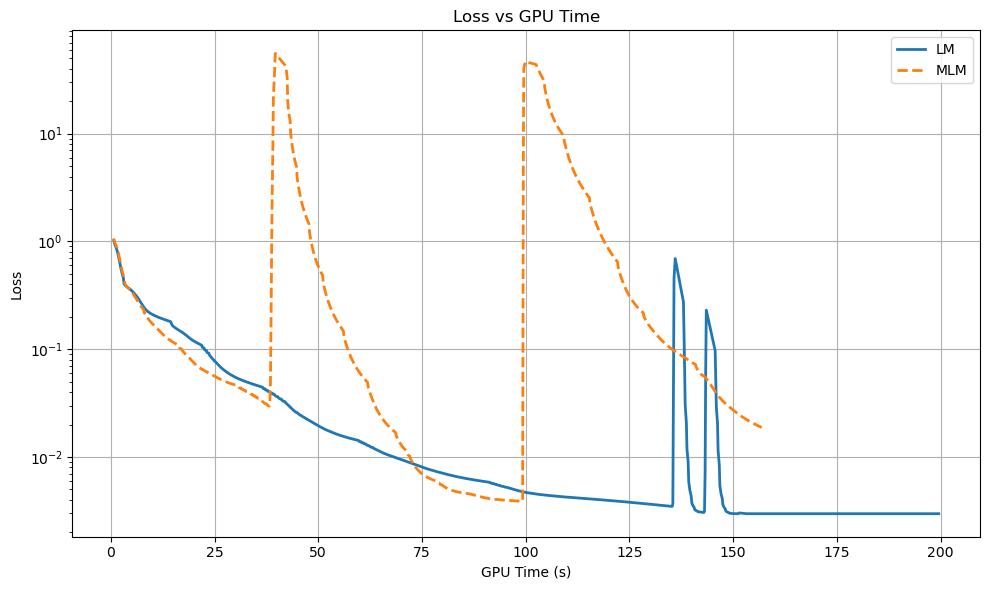

In [ ]:
import torch
import torch.nn as nn
import numpy as np
from functorch import make_functional, vmap, jacrev
# from ucimlrepo import fetch_ucirepo 
import collections
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd


class Network(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size, depth, act=torch.nn.Sigmoid()):
        super(Network, self).__init__()
        layers = []
        layers.append(("layer1", nn.Linear(input_size, hidden_size1)))
        layers.append(("activation1", act))
        if depth >= 2:
            layers.append(("layer2", nn.Linear(hidden_size1, hidden_size2)))
            layers.append(("activation2", act))
            layers.append(("layer3", nn.Linear(hidden_size2, output_size, bias=False)))
        else:
            layers.append(("layer2", nn.Linear(hidden_size1, output_size, bias=False)))
        self.model = nn.Sequential(collections.OrderedDict(layers))
        self.p_number = sum(p.numel() for p in self.model.parameters())

    def forward(self, x):
        return self.model(x)

class PINN_LM:
    def __init__(self, X_data, y_data, cuda_num=7):
        self.device = torch.device(f"cuda:{cuda_num}" if torch.cuda.is_available() else "cpu")
        self.X_data = X_data.to(self.device)
        self.y_data = y_data.to(self.device).view(-1)
        self.data_num = self.X_data.shape[0]

        self.model = Network(self.X_data.shape[1], 70, 70, 1, 2).double().to(self.device)
        self.p_number = self.model.p_number
        torch.set_default_dtype(torch.float64)
        print('model # of parameters:', self.p_number)

        self.loss_record = np.zeros(100000)
        self.time_record = np.zeros(100000)
        self.loss_iter = 0
        self.time_iter = 0
        ## Initial weights
        def initialize_weights(self):
            for m in self.modules():
                if isinstance(m, nn.Linear):
                    nn.init.xavier_normal_(m.weight.data)
                    if m.bias is not None:
                        m.bias.data.zero_()
                        # m.bias.data.normal_(mean=0.0, std=1.0)

        initialize_weights(self.model)
        
    

    def f(self, params, input_data):
        a = 0
        for module in self.model.model.children():
            if isinstance(module, nn.Linear):
                in_f = module.weight.size(1)
                out_f = module.weight.size(0)
                w_size = in_f * out_f
                module.weight.data = params[a:a + w_size].reshape(out_f, in_f).clone()
                a += w_size
                if module.bias is not None:
                    module.bias.data = params[a:a + out_f].clone()
                    a += out_f
        return torch.vmap(self.model)(input_data)

    def fx_fun(self, params):
        preds = self.f(params, self.X_data).view(-1)
        return preds - self.y_data

    def F_fun(self, fx):
        return torch.mean(fx**2)

    def J_func(self, params):
        params.requires_grad_(True)
        func_model, func_params = make_functional(self.model)

        def fm(x, fp): return func_model(fp, x).squeeze()
        def floss(fp, x): return fm(x, fp)

        per_sample_grads = vmap(jacrev(floss), (None, 0))(func_params, self.X_data)
        
        cnt=0
                
        for g in per_sample_grads: 
            g = g.detach()
            J_d = g.reshape(len(g),-1) if cnt == 0 else torch.hstack([J_d,g.reshape(len(g),-1)])
            cnt = 1
        
        result= J_d.detach()
        return result

    def broyden_partial_update(self, J_prev, delta_r, delta_theta, indices):
        with torch.no_grad():
            J_sub = J_prev[:, indices]
            correction = torch.outer((delta_r - J_sub @ delta_theta), delta_theta) / (delta_theta.T @ delta_theta)
            J_new = J_prev.clone()
            J_new[:, indices] = J_sub + correction
        return J_new

    def MLM(self, opt_num=200, step=50,bd_tol=1,zone=1/2):
        p = torch.cat([p.view(-1) for p in self.model.parameters()]).to(self.device)
        J = self.J_func(p)
        mu = 10
        lmin, lmax = 1e-16, 1e100
        lambda_up, lambda_down = 4, 0.25
        yi, yi2 = 1e-16, 1e-5
        alpha = 1
        F_pnew = 1
        k, reject = 0, 0
        elapsed_time_ms=0
        selected_cols = np.random.choice(self.p_number, opt_num, replace=False)
        start_event = torch.cuda.Event(enable_timing=True)
        start_event.record()
        while k < step:
            end_event = torch.cuda.Event(enable_timing=True)
            k += 1
            fx = self.fx_fun(p)
            F_p = self.F_fun(fx)
            J_opt = J[:, selected_cols]
            A_opt =torch.matmul(J_opt.t(),J_opt)
            diag = torch.eye(A_opt.shape[0]).to(self.device)
            H = A_opt + mu * diag
            with torch.no_grad():
                    
                    gk=torch.matmul(J.t(),fx)
                    # gkF=torch.matmul(J_opt.t(),fx)
                    gkF=gk[selected_cols]
            try:              
                    h_lm = torch.linalg.solve(H, -gkF)      
                        
            except:
                    print('singular matrix')

            p_new = p.clone()
            p_new[selected_cols] += alpha * h_lm.view(-1)
            fx_new = self.fx_fun(p_new)
            F_pnew = self.F_fun(fx_new)
            o = F_p - F_pnew
            o_=torch.matmul(gkF.t(),h_lm)+1/2*torch.matmul(h_lm.t(),torch.matmul(A_opt,h_lm))+1/2*mu*torch.norm(h_lm, p=2)

            if o / o_ > yi and torch.norm(gkF)**2 > yi2 / mu:
                reject=0
                self.loss_record[self.loss_iter] = float(F_pnew.item())
                self.loss_iter += 1
                self.time_record[self.time_iter] = elapsed_time_ms/1000
                self.time_iter += 1
                print(f"[{k}] Accept | Loss = {F_p.item():.6f} -> {F_pnew.item():.6f} | parameter #: {opt_num}| time: {elapsed_time_ms}")
                p = p_new
                if reject >= bd_tol:
                    J = self.J_func(p)
                else:
                    J = self.broyden_partial_update(J, fx_new - fx, h_lm.view(-1), selected_cols)
                mu = max(mu * lambda_down, lmin)
                if k%5==0:
                    rho=1/(2*torch.norm(gk,p=2)**4 * mu**2)
                    if rho <=1 :
                        opt_num=int(np.round(self.p_number*torch.sqrt(1-rho).item()))
                        print("optnumber",opt_num)
                        #torch.sqrt(1-1/(2*torch.norm(gk,p=2)**4 * mu**2))
                    else:
                        print('zone')
                        opt_num=int(np.round(zone*self.p_number))
                        
                    selected_cols = np.random.choice(self.p_number, opt_num, replace=False)

            else:
                if reject >= bd_tol:
                    J = self.J_func(p)
                print(f"[{k}] Reject")
                reject += 1
                
                
                mu = min(mu * lambda_up, lmax)
                
            end_event.record()
            torch.cuda.synchronize()  # Wait for the events to be recorded!
            elapsed_time_ms = start_event.elapsed_time(end_event)

        print(f"Training finished. Final loss:{F_pnew.item()}, average time: {elapsed_time_ms/(1000*step)}")
        
        
        
        
        
        
        
        
    def LM(self, opt_num=200, step=50,bd_tol=1):
        p = torch.cat([p.view(-1) for p in self.model.parameters()]).to(self.device)
        J = self.J_func(p)
        mu = 10
        lmin, lmax = 1e-16, 1e100
        lambda_up, lambda_down = 4, 0.25
        yi, yi2 = 1e-16, 1e-5
        alpha = 1
        F_pnew = 1
        k, reject = 0, 0
        elapsed_time_ms=0
        selected_cols = np.random.choice(self.p_number, opt_num, replace=False)
        start_event = torch.cuda.Event(enable_timing=True)
        start_event.record()
        while k < step:
            end_event = torch.cuda.Event(enable_timing=True)
            k += 1
            fx = self.fx_fun(p)
            F_p = self.F_fun(fx)
            J_opt = J[:, selected_cols]
            A_opt =torch.matmul(J_opt.t(),J_opt)
            diag = torch.eye(A_opt.shape[0]).to(self.device)
            H = A_opt + mu * diag
            with torch.no_grad():
                    # gkF=torch.matmul(J_opt.t(),fx)
                    
                    gk=torch.matmul(J.t(),fx)
                    gkF=gk[selected_cols]
            try:              
                    h_lm = torch.linalg.solve(H, -gkF)      
                        
            except:
                    print('singular matrix')

            p_new = p.clone()
            p_new[selected_cols] += alpha * h_lm.view(-1)
            fx_new = self.fx_fun(p_new)
            F_pnew = self.F_fun(fx_new)
            o = F_p - F_pnew
            o_=torch.matmul(gkF.t(),h_lm)+1/2*torch.matmul(h_lm.t(),torch.matmul(A_opt,h_lm))+1/2*mu*torch.norm(h_lm, p=2)

            if o / o_ > yi and torch.norm(gkF)**2 > yi2 / mu:
                reject=0
                self.loss_record[self.loss_iter] = float(F_pnew.item())
                self.loss_iter += 1
                self.time_record[self.time_iter] = elapsed_time_ms/1000
                self.time_iter += 1
                print(f"[{k}] Accept | Loss = {F_p.item():.6f} -> {F_pnew.item():.6f} | parameter #: {opt_num}| time: {elapsed_time_ms}")
                p = p_new
                if reject >= bd_tol:
                    J = self.J_func(p)
                else:
                    J = self.broyden_partial_update(J, fx_new - fx, h_lm.view(-1), selected_cols)
                mu = max(mu * lambda_down, lmin)
                
            else:
                if reject >= bd_tol:
                    J = self.J_func(p)
                print(f"[{k}] Reject")
                reject += 1
                
                mu = min(mu * lambda_up, lmax)
            end_event.record()
            torch.cuda.synchronize()  # Wait for the events to be recorded!
            elapsed_time_ms = start_event.elapsed_time(end_event)

        print(f"Training finished. Final loss:{F_pnew.item()}, average time: {elapsed_time_ms/(1000*step)}")
def plot_loss_vs_time(loss1, time1, loss2, time2, label1="LM", label2="MLM"):
        loss1 = loss1[time1 != 0]
        time1 = time1[time1 != 0]
        loss2 = loss2[time2 != 0]
        time2 = time2[time2 != 0]

        plt.figure(figsize=(10, 6))
        plt.plot(time1, loss1, label=label1, linewidth=2)
        plt.plot(time2, loss2, label=label2, linestyle='--', linewidth=2)

        plt.xlabel("GPU Time (s)")
        plt.ylabel("Loss")
        plt.title("Loss vs GPU Time")
        plt.yscale("log")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
# === 训练入口 ===
if __name__ == "__main__":

    # 读取 Excel 文件
    df = pd.read_excel("/home/zhy/Zhou/lm/Ccs/Concrete_Data.xls")

    # 显示列名（确认目标列是哪一个）
    # print(df.columns)

    # 假设最后一列是目标变量（Strength）
    X = df.iloc[:, :-1]  # 所有列（除最后一列）为特征
    y = df.iloc[:, -1]   # 最后一列为目标

    scaler_X = StandardScaler()
    scaler_y = StandardScaler()

    X_scaled = scaler_X.fit_transform(X)
    y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))
    print(y_scaled)

    
    # X_tensor = torch.tensor(X.values, dtype=torch.float64)
    # y_tensor = torch.tensor(y.values.reshape(-1, 1), dtype=torch.float64)
    X_tensor = torch.tensor(X_scaled, dtype=torch.float64)
    y_tensor = torch.tensor(y_scaled, dtype=torch.float64)
    print(X_tensor.shape)

    # 训练 LM
    model_lm = PINN_LM(X_tensor, y_tensor)
    model_lm.LM(opt_num=5670, step=1400,bd_tol=0)

    # 训练 MLM
    model_mlm = PINN_LM(X_tensor, y_tensor)
    model_mlm.MLM(opt_num=5670, step=1400,bd_tol=0)

    # 绘图对比
    plot_loss_vs_time(
        model_lm.loss_record, model_lm.time_record,
        model_mlm.loss_record, model_mlm.time_record,
        label1="LM", label2="MLM"
    )

[[ 2.64519215]
 [ 1.5612771 ]
 [ 0.26660766]
 ...
 [-0.7259282 ]
 [-0.18264932]
 [-0.20461667]]
torch.Size([1030, 8])
model # of parameters: 5670


<ipython-input-5-f5318cb19eb3>:83: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.make_functional` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.func.functional_call` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  func_model, func_params = make_functional(self.model)
<ipython-input-5-f5318cb19eb3>:88: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.jacrev` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.func.jacrev` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  per_sample_grads = vmap(jacrev(floss), (None, 0))(func_params, self.X_data)
<ipython

[1] Accept | Loss = 1.003617 -> 0.968133 | parameter #: 5670| time: 0
[2] Accept | Loss = 0.968133 -> 0.927244 | parameter #: 5670| time: 337.17657470703125
[3] Accept | Loss = 0.927244 -> 0.839868 | parameter #: 5670| time: 527.9569702148438
[4] Reject
[5] Reject
[6] Accept | Loss = 0.839868 -> 0.754392 | parameter #: 5670| time: 1150.6851806640625
[7] Reject
[8] Accept | Loss = 0.754392 -> 0.663305 | parameter #: 5670| time: 1566.1219482421875
[9] Reject
[10] Accept | Loss = 0.663305 -> 0.574302 | parameter #: 5670| time: 2014.2940673828125
[11] Accept | Loss = 0.574302 -> 0.472099 | parameter #: 5670| time: 2239.476806640625
[12] Reject
[13] Accept | Loss = 0.472099 -> 0.419670 | parameter #: 5670| time: 2673.35986328125
[14] Accept | Loss = 0.419670 -> 0.392332 | parameter #: 5670| time: 2886.855712890625
[15] Accept | Loss = 0.392332 -> 0.372758 | parameter #: 5670| time: 3099.8251953125
[16] Reject
[17] Accept | Loss = 0.372758 -> 0.352700 | parameter #: 5670| time: 3528.60253906

<ipython-input-5-f5318cb19eb3>:103: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647369228/work/aten/src/ATen/native/TensorShape.cpp:3683.)
  correction = torch.outer((delta_r - J_sub @ delta_theta), delta_theta) / (delta_theta.T @ delta_theta)


[13] Accept | Loss = 1.005041 -> 0.986529 | parameter #: 5670| time: 2449.2841796875
[14] Accept | Loss = 0.986529 -> 0.958919 | parameter #: 5670| time: 2616.029296875
[15] Accept | Loss = 0.958919 -> 0.909185 | parameter #: 5670| time: 2795.976806640625
optnumber 5670
[16] Accept | Loss = 0.909185 -> 0.827329 | parameter #: 5670| time: 2986.55126953125
[17] Reject
[18] Accept | Loss = 0.827329 -> 0.761674 | parameter #: 5670| time: 3371.75048828125
[19] Reject
[20] Accept | Loss = 0.761674 -> 0.708623 | parameter #: 5670| time: 3762.8876953125
optnumber 5670
[21] Reject
[22] Accept | Loss = 0.708623 -> 0.665307 | parameter #: 5670| time: 4160.0439453125
[23] Accept | Loss = 0.665307 -> 0.601822 | parameter #: 5670| time: 4352.55517578125
[24] Reject
[25] Accept | Loss = 0.601822 -> 0.556555 | parameter #: 5670| time: 4760.09765625
optnumber 5670
[26] Reject
[27] Accept | Loss = 0.556555 -> 0.523631 | parameter #: 5670| time: 5158.65380859375
[28] Reject
[29] Accept | Loss = 0.523631 

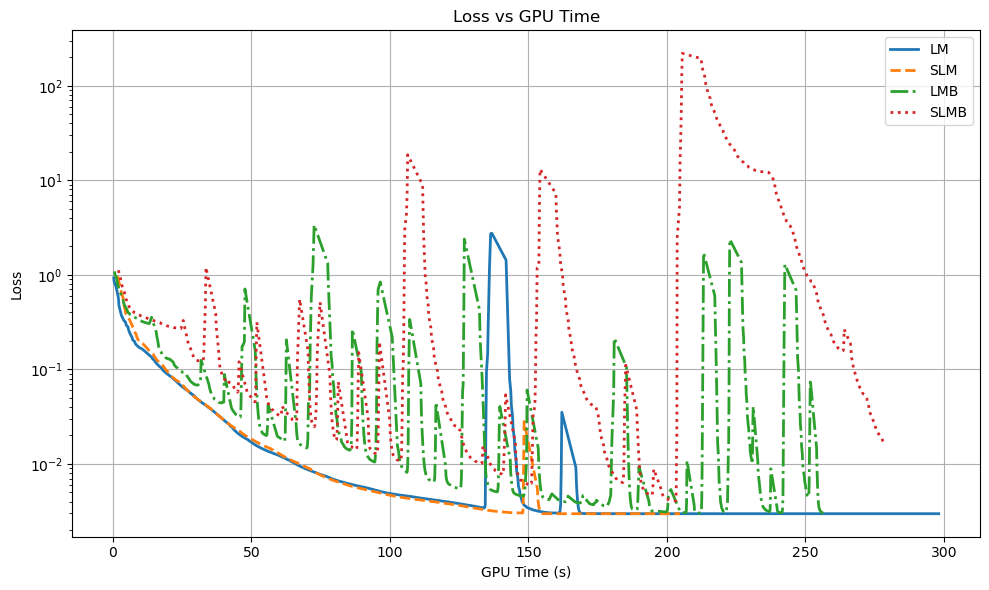

In [ ]:
import torch
import torch.nn as nn
import numpy as np
from functorch import make_functional, vmap, jacrev
# from ucimlrepo import fetch_ucirepo 
import collections
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd


class Network(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size, depth, act=torch.nn.Sigmoid()):
        super(Network, self).__init__()
        layers = []
        layers.append(("layer1", nn.Linear(input_size, hidden_size1)))
        layers.append(("activation1", act))
        if depth >= 2:
            layers.append(("layer2", nn.Linear(hidden_size1, hidden_size2)))
            layers.append(("activation2", act))
            layers.append(("layer3", nn.Linear(hidden_size2, output_size, bias=False)))
        else:
            layers.append(("layer2", nn.Linear(hidden_size1, output_size, bias=False)))
        self.model = nn.Sequential(collections.OrderedDict(layers))
        self.p_number = sum(p.numel() for p in self.model.parameters())

    def forward(self, x):
        return self.model(x)

class PINN_LM:
    def __init__(self, X_data, y_data, cuda_num=6):
        self.device = torch.device(f"cuda:{cuda_num}" if torch.cuda.is_available() else "cpu")
        self.X_data = X_data.to(self.device)
        self.y_data = y_data.to(self.device).view(-1)
        self.data_num = self.X_data.shape[0]
        torch.set_default_dtype(torch.float64)
        self.model = Network(self.X_data.shape[1],70, 70, 1, 2).double().to(self.device)
        self.p_number = self.model.p_number

        print('model # of parameters:', self.p_number)

        self.loss_record = np.zeros(100000)
        self.time_record = np.zeros(100000)
        self.loss_iter = 0
        self.time_iter = 0
        ## Initial weights
        def initialize_weights(self):
            for m in self.modules():
                if isinstance(m, nn.Linear):
                    nn.init.xavier_normal_(m.weight.data)
                    if m.bias is not None:
                        m.bias.data.zero_()
                        # m.bias.data.normal_(mean=0.0, std=1.0)

        initialize_weights(self.model)
        
    

    def f(self, params, input_data):
        a = 0
        for module in self.model.model.children():
            if isinstance(module, nn.Linear):
                in_f = module.weight.size(1)
                out_f = module.weight.size(0)
                w_size = in_f * out_f
                module.weight.data = params[a:a + w_size].reshape(out_f, in_f).clone()
                a += w_size
                if module.bias is not None:
                    module.bias.data = params[a:a + out_f].clone()
                    a += out_f
        return torch.vmap(self.model)(input_data)

    def fx_fun(self, params):
        preds = self.f(params, self.X_data).view(-1)
        return preds - self.y_data

    def F_fun(self, fx):
        return torch.mean(fx**2)

    def J_func(self, params):
        params.requires_grad_(True)
        func_model, func_params = make_functional(self.model)

        def fm(x, fp): return func_model(fp, x).squeeze()
        def floss(fp, x): return fm(x, fp)

        per_sample_grads = vmap(jacrev(floss), (None, 0))(func_params, self.X_data)
        
        cnt=0
                
        for g in per_sample_grads: 
            g = g.detach()
            J_d = g.reshape(len(g),-1) if cnt == 0 else torch.hstack([J_d,g.reshape(len(g),-1)])
            cnt = 1
        
        result= J_d.detach()
        return result

    def broyden_partial_update(self, J_prev, delta_r, delta_theta, indices):
        with torch.no_grad():
            J_sub = J_prev[:, indices]
            correction = torch.outer((delta_r - J_sub @ delta_theta), delta_theta) / (delta_theta.T @ delta_theta)
            J_new = J_prev.clone()
            J_new[:, indices] = J_sub + correction
        return J_new

    def SLM(self, opt_num=200, step=50,bd_tol=0,zone=2/3):
        p = torch.cat([p.view(-1) for p in self.model.parameters()]).to(self.device)
        J = self.J_func(p)
        mu = 10
        lmin, lmax = 1e-16, 1e100
        lambda_up, lambda_down = 2, 0.5
        yi, yi2 = 1e-16, 1e-5
        alpha = 1
        F_pnew = 1
        k, reject = 0, 0
        elapsed_time_ms=0
        selected_cols = np.random.choice(self.p_number, opt_num, replace=False)
        start_event = torch.cuda.Event(enable_timing=True)
        start_event.record()
        while k < step:
            end_event = torch.cuda.Event(enable_timing=True)
            k += 1
            fx = self.fx_fun(p)
            F_p = self.F_fun(fx)
            J_opt = J[:, selected_cols]
            A_opt =torch.matmul(J_opt.t(),J_opt)
            diag = torch.eye(A_opt.shape[0]).to(self.device)
            H = A_opt + mu * diag
            with torch.no_grad():
                    
                    gk=torch.matmul(J.t(),fx)
                    # gkF=torch.matmul(J_opt.t(),fx)
                    gkF=gk[selected_cols]
            try:              
                    h_lm = torch.linalg.solve(H, -gkF)      
                        
            except:
                    print('singular matrix')

            p_new = p.clone()
            p_new[selected_cols] += alpha * h_lm.view(-1)
            fx_new = self.fx_fun(p_new)
            F_pnew = self.F_fun(fx_new)
            o = F_p - F_pnew
            o_=torch.matmul(gkF.t(),h_lm)+1/2*torch.matmul(h_lm.t(),torch.matmul(A_opt,h_lm))+1/2*mu*torch.norm(h_lm, p=2)

            if o / o_ > yi and torch.norm(gkF)**2 > yi2 / mu:
                reject=0
                self.loss_record[self.loss_iter] = float(F_pnew.item())
                self.loss_iter += 1
                self.time_record[self.time_iter] = elapsed_time_ms/1000
                self.time_iter += 1
                print(f"[{k}] Accept | Loss = {F_p.item():.6f} -> {F_pnew.item():.6f} | parameter #: {opt_num}| time: {elapsed_time_ms}")
                p = p_new
                if reject >= bd_tol:
                    J = self.J_func(p)
                else:
                    J = self.broyden_partial_update(J, fx_new - fx, h_lm.view(-1), selected_cols)
                mu = max(mu * lambda_down, lmin)
                if k%5==0:
                    rho=1/(2*torch.norm(gk,p=2)**4 * mu**2)
                    if rho <=1 :
                        opt_num=int(np.round(self.p_number*torch.sqrt(1-rho).item()))
                        print("optnumber",opt_num)
                        #torch.sqrt(1-1/(2*torch.norm(gk,p=2)**4 * mu**2))
                    else:
                        print('zone')
                        opt_num=int(np.round(zone*self.p_number))
                        
                    selected_cols = np.random.choice(self.p_number, opt_num, replace=False)

            else:
                if reject >= bd_tol:
                    J = self.J_func(p)
                print(f"[{k}] Reject")
                reject += 1
                
                
                mu = min(mu * lambda_up, lmax)
                
            end_event.record()
            torch.cuda.synchronize()  # Wait for the events to be recorded!
            elapsed_time_ms = start_event.elapsed_time(end_event)
        
        self.time_record[self.time_iter] = elapsed_time_ms/1000
        self.loss_record[self.loss_iter] = float(F_pnew.item())
        print(f"Training finished. Final loss:{F_pnew.item()}, average time: {elapsed_time_ms/(1000*step)}")
        
        
        
        
        
        
        
        
    def LM(self, opt_num=200, step=50,bd_tol=0):
        p = torch.cat([p.view(-1) for p in self.model.parameters()]).to(self.device)
        J = self.J_func(p)
        mu = 1000
        lmin, lmax = 1e-16, 1e100
        lambda_up, lambda_down = 2, 0.5
        yi, yi2 = 1e-16, 1e-5
        alpha = 1
        F_pnew = 1
        k, reject = 0, 0
        elapsed_time_ms=0
        selected_cols = np.random.choice(self.p_number, opt_num, replace=False)
        start_event = torch.cuda.Event(enable_timing=True)
        start_event.record()
        while k < step:
            end_event = torch.cuda.Event(enable_timing=True)
            k += 1
            fx = self.fx_fun(p)
            F_p = self.F_fun(fx)
            J_opt = J[:, selected_cols]
            A_opt =torch.matmul(J_opt.t(),J_opt)
            diag = torch.eye(A_opt.shape[0]).to(self.device)
            H = A_opt + mu * diag
            with torch.no_grad():
                    # gkF=torch.matmul(J_opt.t(),fx)
                    
                    gk=torch.matmul(J.t(),fx)
                    gkF=gk[selected_cols]
            try:              
                    h_lm = torch.linalg.solve(H, -gkF)      
                        
            except:
                    print('singular matrix')

            p_new = p.clone()
            p_new[selected_cols] += alpha * h_lm.view(-1)
            fx_new = self.fx_fun(p_new)
            F_pnew = self.F_fun(fx_new)
            o = F_p - F_pnew
            o_=torch.matmul(gkF.t(),h_lm)+1/2*torch.matmul(h_lm.t(),torch.matmul(A_opt,h_lm))+1/2*mu*torch.norm(h_lm, p=2)

            if o / o_ > yi and torch.norm(gkF)**2 > yi2 / mu:
                reject=0
                self.loss_record[self.loss_iter] = float(F_pnew.item())
                self.loss_iter += 1
                self.time_record[self.time_iter] = elapsed_time_ms/1000
                self.time_iter += 1
                print(f"[{k}] Accept | Loss = {F_p.item():.6f} -> {F_pnew.item():.6f} | parameter #: {opt_num}| time: {elapsed_time_ms}")
                p = p_new
                if reject >= bd_tol:
                    J = self.J_func(p)
                else:
                    J = self.broyden_partial_update(J, fx_new - fx, h_lm.view(-1), selected_cols)
                mu = max(mu * lambda_down, lmin)
                
            else:
                if reject >= bd_tol:
                    J = self.J_func(p)
                print(f"[{k}] Reject")
                reject += 1
                
                mu = min(mu * lambda_up, lmax)
            end_event.record()
            torch.cuda.synchronize()  # Wait for the events to be recorded!
            elapsed_time_ms = start_event.elapsed_time(end_event)
        self.time_record[self.time_iter] = elapsed_time_ms/1000
        self.loss_record[self.loss_iter] = float(F_pnew.item())

        print(f"Training finished. Final loss:{F_pnew.item()}, average time: {elapsed_time_ms/(1000*step)}")

def plot_loss_vs_time(loss1, time1, loss2, time2,loss3,time3,loss4,time4, label1="LM", label2="SLM",label3="LMB",label4="SLMB"):
        loss1 = loss1[time1 != 0]
        time1 = time1[time1 != 0]
        loss2 = loss2[time2 != 0]
        time2 = time2[time2 != 0]
        loss3 = loss3[time3!= 0]
        time3 = time3[time3 != 0]
        loss4 = loss4[time4 != 0]
        time4 = time4[time4 != 0]

        plt.figure(figsize=(10, 6))
        plt.plot(time1, loss1, label=label1, linestyle='-',  color='#1f77b4', linewidth=2)  # muted blue
        plt.plot(time2, loss2, label=label2, linestyle='--', color='#ff7f0e', linewidth=2)  # muted orange
        plt.plot(time3, loss3, label=label3, linestyle='-.', color='#2ca02c', linewidth=2)  # muted green
        plt.plot(time4, loss4, label=label4, linestyle=':',  color='#d62728', linewidth=2)  # muted red
                

        plt.xlabel("GPU Time (s)")
        plt.ylabel("Loss")
        plt.title("Loss vs GPU Time")
        plt.yscale("log")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
# === 训练入口 ===
if __name__ == "__main__":

    # 读取 Excel 文件
    df = pd.read_excel("/home/zhy/Zhou/lm/Ccs/Concrete_Data.xls")

    # 显示列名（确认目标列是哪一个）
    # print(df.columns)

    # 假设最后一列是目标变量（Strength）
    X = df.iloc[:, :-1]  # 所有列（除最后一列）为特征
    y = df.iloc[:, -1]   # 最后一列为目标

    scaler_X = StandardScaler()
    scaler_y = StandardScaler()

    X_scaled = scaler_X.fit_transform(X)
    y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))
    print(y_scaled)

    
    # X_tensor = torch.tensor(X.values, dtype=torch.float64)
    # y_tensor = torch.tensor(y.values.reshape(-1, 1), dtype=torch.float64)
    X_tensor = torch.tensor(X_scaled, dtype=torch.float64)
    y_tensor = torch.tensor(y_scaled, dtype=torch.float64)
    print(X_tensor.shape)

    # 训练 LM
    model_lm = PINN_LM(X_tensor, y_tensor)
    model_lm.LM(opt_num=5670, step=1400,bd_tol=0)

    # 训练 MLM
    model_slm = PINN_LM(X_tensor, y_tensor)
    model_slm.SLM(opt_num=5670, step=1400,bd_tol=0,zone=2/3)
    
    
    model_slmb = PINN_LM(X_tensor, y_tensor)
    model_slmb.SLM(opt_num=5670, step=1400,bd_tol=1,zone=2/3)
    
    model_lmb = PINN_LM(X_tensor, y_tensor)
    model_lmb.LM(opt_num=5670, step=1400,bd_tol=1)
    
    # 绘图对比
    plot_loss_vs_time(
        model_lm.loss_record, model_lm.time_record,
        model_slm.loss_record, model_slm.time_record,
        model_lmb.loss_record, model_lmb.time_record,
        model_slmb.loss_record, model_slmb.time_record,
    )

[[ 2.64519215]
 [ 1.5612771 ]
 [ 0.26660766]
 ...
 [-0.7259282 ]
 [-0.18264932]
 [-0.20461667]]
torch.Size([1030, 8])
model # of parameters: 5670


<ipython-input-6-f5318cb19eb3>:83: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.make_functional` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.func.functional_call` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  func_model, func_params = make_functional(self.model)
<ipython-input-6-f5318cb19eb3>:88: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.jacrev` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.func.jacrev` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  per_sample_grads = vmap(jacrev(floss), (None, 0))(func_params, self.X_data)
<ipython

[1] Reject
[2] Accept | Loss = 1.102430 -> 0.963316 | parameter #: 5670| time: 202.77760314941406
[3] Accept | Loss = 0.963316 -> 0.925936 | parameter #: 5670| time: 425.92462158203125
[4] Accept | Loss = 0.925936 -> 0.855871 | parameter #: 5670| time: 639.0599975585938
[5] Reject
[6] Accept | Loss = 0.855871 -> 0.764251 | parameter #: 5670| time: 1074.33056640625
[7] Reject
[8] Accept | Loss = 0.764251 -> 0.663010 | parameter #: 5670| time: 1505.2236328125
[9] Reject
[10] Accept | Loss = 0.663010 -> 0.568673 | parameter #: 5670| time: 1951.1265869140625
[11] Accept | Loss = 0.568673 -> 0.465280 | parameter #: 5670| time: 2125.05908203125
[12] Reject
[13] Accept | Loss = 0.465280 -> 0.414608 | parameter #: 5670| time: 2500.79638671875
[14] Accept | Loss = 0.414608 -> 0.389040 | parameter #: 5670| time: 2702.415771484375
[15] Accept | Loss = 0.389040 -> 0.373272 | parameter #: 5670| time: 2910.381103515625
[16] Reject
[17] Accept | Loss = 0.373272 -> 0.357183 | parameter #: 5670| time: 

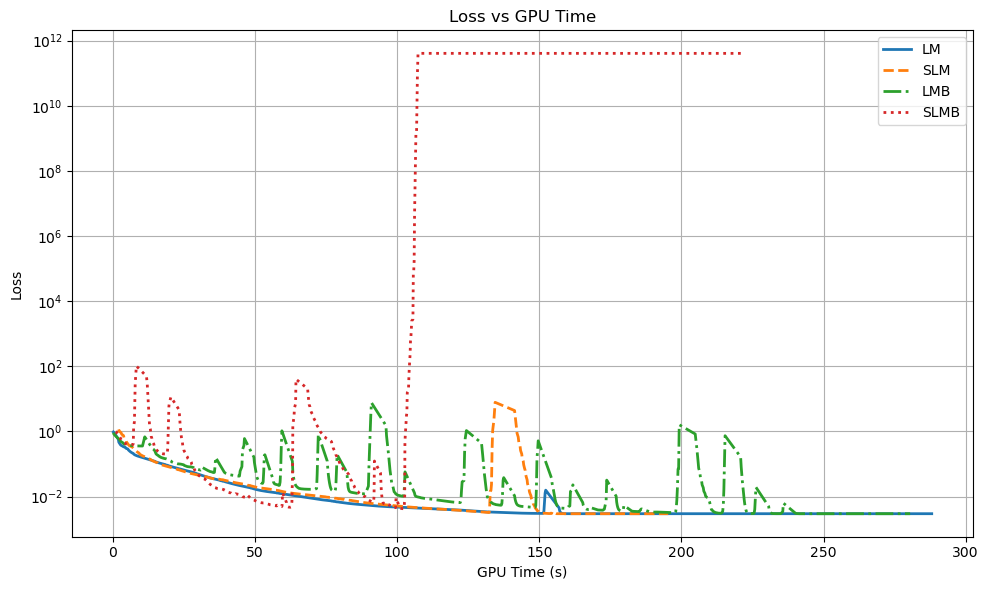

In [ ]:
import torch
import torch.nn as nn
import numpy as np
from functorch import make_functional, vmap, jacrev
# from ucimlrepo import fetch_ucirepo 
import collections
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd


class Network(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size, depth, act=torch.nn.Sigmoid()):
        super(Network, self).__init__()
        layers = []
        layers.append(("layer1", nn.Linear(input_size, hidden_size1)))
        layers.append(("activation1", act))
        if depth >= 2:
            layers.append(("layer2", nn.Linear(hidden_size1, hidden_size2)))
            layers.append(("activation2", act))
            layers.append(("layer3", nn.Linear(hidden_size2, output_size, bias=False)))
        else:
            layers.append(("layer2", nn.Linear(hidden_size1, output_size, bias=False)))
        self.model = nn.Sequential(collections.OrderedDict(layers))
        self.p_number = sum(p.numel() for p in self.model.parameters())

    def forward(self, x):
        return self.model(x)

class PINN_LM:
    def __init__(self, X_data, y_data, cuda_num=6):
        self.device = torch.device(f"cuda:{cuda_num}" if torch.cuda.is_available() else "cpu")
        self.X_data = X_data.to(self.device)
        self.y_data = y_data.to(self.device).view(-1)
        self.data_num = self.X_data.shape[0]
        torch.set_default_dtype(torch.float64)
        self.model = Network(self.X_data.shape[1],70, 70, 1, 2).double().to(self.device)
        self.p_number = self.model.p_number

        print('model # of parameters:', self.p_number)

        self.loss_record = np.zeros(100000)
        self.time_record = np.zeros(100000)
        self.loss_iter = 0
        self.time_iter = 0
        ## Initial weights
        def initialize_weights(self):
            for m in self.modules():
                if isinstance(m, nn.Linear):
                    nn.init.xavier_normal_(m.weight.data)
                    if m.bias is not None:
                        m.bias.data.zero_()
                        # m.bias.data.normal_(mean=0.0, std=1.0)

        initialize_weights(self.model)
        
    

    def f(self, params, input_data):
        a = 0
        for module in self.model.model.children():
            if isinstance(module, nn.Linear):
                in_f = module.weight.size(1)
                out_f = module.weight.size(0)
                w_size = in_f * out_f
                module.weight.data = params[a:a + w_size].reshape(out_f, in_f).clone()
                a += w_size
                if module.bias is not None:
                    module.bias.data = params[a:a + out_f].clone()
                    a += out_f
        return torch.vmap(self.model)(input_data)

    def fx_fun(self, params):
        preds = self.f(params, self.X_data).view(-1)
        return preds - self.y_data

    def F_fun(self, fx):
        return torch.mean(fx**2)

    def J_func(self, params):
        params.requires_grad_(True)
        func_model, func_params = make_functional(self.model)

        def fm(x, fp): return func_model(fp, x).squeeze()
        def floss(fp, x): return fm(x, fp)

        per_sample_grads = vmap(jacrev(floss), (None, 0))(func_params, self.X_data)
        
        cnt=0
                
        for g in per_sample_grads: 
            g = g.detach()
            J_d = g.reshape(len(g),-1) if cnt == 0 else torch.hstack([J_d,g.reshape(len(g),-1)])
            cnt = 1
        
        result= J_d.detach()
        return result

    def broyden_partial_update(self, J_prev, delta_r, delta_theta, indices):
        with torch.no_grad():
            J_sub = J_prev[:, indices]
            correction = torch.outer((delta_r - J_sub @ delta_theta), delta_theta) / (delta_theta.T @ delta_theta)
            J_new = J_prev.clone()
            J_new[:, indices] = J_sub + correction
        return J_new

    def SLM(self, opt_num=200, step=50,bd_tol=0,zone=2/3):
        p = torch.cat([p.view(-1) for p in self.model.parameters()]).to(self.device)
        J = self.J_func(p)
        mu = 10
        lmin, lmax = 1e-16, 1e100
        lambda_up, lambda_down = 2, 0.5
        yi, yi2 = 1e-16, 1e-5
        alpha = 1
        F_pnew = 1
        k, reject = 0, 0
        elapsed_time_ms=0
        selected_cols = np.random.choice(self.p_number, opt_num, replace=False)
        start_event = torch.cuda.Event(enable_timing=True)
        start_event.record()
        while k < step:
            end_event = torch.cuda.Event(enable_timing=True)
            k += 1
            fx = self.fx_fun(p)
            F_p = self.F_fun(fx)
            J_opt = J[:, selected_cols]
            A_opt =torch.matmul(J_opt.t(),J_opt)
            diag = torch.eye(A_opt.shape[0]).to(self.device)
            H = A_opt + mu * diag
            with torch.no_grad():
                    
                    gk=torch.matmul(J.t(),fx)
                    # gkF=torch.matmul(J_opt.t(),fx)
                    gkF=gk[selected_cols]
            try:              
                    h_lm = torch.linalg.solve(H, -gkF)      
                        
            except:
                    print('singular matrix')

            p_new = p.clone()
            p_new[selected_cols] += alpha * h_lm.view(-1)
            fx_new = self.fx_fun(p_new)
            F_pnew = self.F_fun(fx_new)
            o = F_p - F_pnew
            o_=torch.matmul(gkF.t(),h_lm)+1/2*torch.matmul(h_lm.t(),torch.matmul(A_opt,h_lm))+1/2*mu*torch.norm(h_lm, p=2)

            if o / o_ > yi and torch.norm(gkF)**2 > yi2 / mu:
                reject=0
                self.loss_record[self.loss_iter] = float(F_pnew.item())
                self.loss_iter += 1
                self.time_record[self.time_iter] = elapsed_time_ms/1000
                self.time_iter += 1
                print(f"[{k}] Accept | Loss = {F_p.item():.6f} -> {F_pnew.item():.6f} | parameter #: {opt_num}| time: {elapsed_time_ms}")
                p = p_new
                if reject >= bd_tol:
                    J = self.J_func(p)
                else:
                    J = self.broyden_partial_update(J, fx_new - fx, h_lm.view(-1), selected_cols)
                mu = max(mu * lambda_down, lmin)
                if k%5==0:
                    rho=1/(2*torch.norm(gk,p=2)**4 * mu**2)
                    if rho <=1 :
                        opt_num=int(np.round(self.p_number*torch.sqrt(1-rho).item()))
                        print("optnumber",opt_num)
                        #torch.sqrt(1-1/(2*torch.norm(gk,p=2)**4 * mu**2))
                    else:
                        print('zone')
                        opt_num=int(np.round(zone*self.p_number))
                        
                    selected_cols = np.random.choice(self.p_number, opt_num, replace=False)

            else:
                if reject >= bd_tol:
                    J = self.J_func(p)
                print(f"[{k}] Reject")
                reject += 1
                
                
                mu = min(mu * lambda_up, lmax)
                
            end_event.record()
            torch.cuda.synchronize()  # Wait for the events to be recorded!
            elapsed_time_ms = start_event.elapsed_time(end_event)
        
        self.time_record[self.time_iter] = elapsed_time_ms/1000
        self.loss_record[self.loss_iter] = float(F_pnew.item())
        print(f"Training finished. Final loss:{F_pnew.item()}, average time: {elapsed_time_ms/(1000*step)}")
        
        
        
        
        
        
        
        
    def LM(self, opt_num=200, step=50,bd_tol=0):
        p = torch.cat([p.view(-1) for p in self.model.parameters()]).to(self.device)
        J = self.J_func(p)
        mu = 1000
        lmin, lmax = 1e-16, 1e100
        lambda_up, lambda_down = 2, 0.5
        yi, yi2 = 1e-16, 1e-5
        alpha = 1
        F_pnew = 1
        k, reject = 0, 0
        elapsed_time_ms=0
        selected_cols = np.random.choice(self.p_number, opt_num, replace=False)
        start_event = torch.cuda.Event(enable_timing=True)
        start_event.record()
        while k < step:
            end_event = torch.cuda.Event(enable_timing=True)
            k += 1
            fx = self.fx_fun(p)
            F_p = self.F_fun(fx)
            J_opt = J[:, selected_cols]
            A_opt =torch.matmul(J_opt.t(),J_opt)
            diag = torch.eye(A_opt.shape[0]).to(self.device)
            H = A_opt + mu * diag
            with torch.no_grad():
                    # gkF=torch.matmul(J_opt.t(),fx)
                    
                    gk=torch.matmul(J.t(),fx)
                    gkF=gk[selected_cols]
            try:              
                    h_lm = torch.linalg.solve(H, -gkF)      
                        
            except:
                    print('singular matrix')

            p_new = p.clone()
            p_new[selected_cols] += alpha * h_lm.view(-1)
            fx_new = self.fx_fun(p_new)
            F_pnew = self.F_fun(fx_new)
            o = F_p - F_pnew
            o_=torch.matmul(gkF.t(),h_lm)+1/2*torch.matmul(h_lm.t(),torch.matmul(A_opt,h_lm))+1/2*mu*torch.norm(h_lm, p=2)

            if o / o_ > yi and torch.norm(gkF)**2 > yi2 / mu:
                reject=0
                self.loss_record[self.loss_iter] = float(F_pnew.item())
                self.loss_iter += 1
                self.time_record[self.time_iter] = elapsed_time_ms/1000
                self.time_iter += 1
                print(f"[{k}] Accept | Loss = {F_p.item():.6f} -> {F_pnew.item():.6f} | parameter #: {opt_num}| time: {elapsed_time_ms}")
                p = p_new
                if reject >= bd_tol:
                    J = self.J_func(p)
                else:
                    J = self.broyden_partial_update(J, fx_new - fx, h_lm.view(-1), selected_cols)
                mu = max(mu * lambda_down, lmin)
                
            else:
                if reject >= bd_tol:
                    J = self.J_func(p)
                print(f"[{k}] Reject")
                reject += 1
                
                mu = min(mu * lambda_up, lmax)
            end_event.record()
            torch.cuda.synchronize()  # Wait for the events to be recorded!
            elapsed_time_ms = start_event.elapsed_time(end_event)
        self.time_record[self.time_iter] = elapsed_time_ms/1000
        self.loss_record[self.loss_iter] = float(F_pnew.item())

        print(f"Training finished. Final loss:{F_pnew.item()}, average time: {elapsed_time_ms/(1000*step)}")

def plot_loss_vs_time(loss1, time1, loss2, time2,loss3,time3,loss4,time4, label1="LM", label2="SLM",label3="LMB",label4="SLMB"):
        loss1 = loss1[time1 != 0]
        time1 = time1[time1 != 0]
        loss2 = loss2[time2 != 0]
        time2 = time2[time2 != 0]
        loss3 = loss3[time3!= 0]
        time3 = time3[time3 != 0]
        loss4 = loss4[time4 != 0]
        time4 = time4[time4 != 0]

        plt.figure(figsize=(10, 6))
        plt.plot(time1, loss1, label=label1, linestyle='-',  color='#1f77b4', linewidth=2)  # muted blue
        plt.plot(time2, loss2, label=label2, linestyle='--', color='#ff7f0e', linewidth=2)  # muted orange
        plt.plot(time3, loss3, label=label3, linestyle='-.', color='#2ca02c', linewidth=2)  # muted green
        plt.plot(time4, loss4, label=label4, linestyle=':',  color='#d62728', linewidth=2)  # muted red
                

        plt.xlabel("GPU Time (s)")
        plt.ylabel("Loss")
        plt.title("Loss vs GPU Time")
        plt.yscale("log")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
# === 训练入口 ===
if __name__ == "__main__":

    # 读取 Excel 文件
    df = pd.read_excel("/home/zhy/Zhou/lm/Ccs/Concrete_Data.xls")

    # 显示列名（确认目标列是哪一个）
    # print(df.columns)

    # 假设最后一列是目标变量（Strength）
    X = df.iloc[:, :-1]  # 所有列（除最后一列）为特征
    y = df.iloc[:, -1]   # 最后一列为目标

    scaler_X = StandardScaler()
    scaler_y = StandardScaler()

    X_scaled = scaler_X.fit_transform(X)
    y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))
    print(y_scaled)

    
    # X_tensor = torch.tensor(X.values, dtype=torch.float64)
    # y_tensor = torch.tensor(y.values.reshape(-1, 1), dtype=torch.float64)
    X_tensor = torch.tensor(X_scaled, dtype=torch.float64)
    y_tensor = torch.tensor(y_scaled, dtype=torch.float64)
    print(X_tensor.shape)

    # 训练 LM
    model_lm = PINN_LM(X_tensor, y_tensor)
    model_lm.LM(opt_num=5670, step=1400,bd_tol=0)

    # 训练 MLM
    model_slm = PINN_LM(X_tensor, y_tensor)
    model_slm.SLM(opt_num=5670, step=1400,bd_tol=0,zone=2/3)
    
    
    model_slmb = PINN_LM(X_tensor, y_tensor)
    model_slmb.SLM(opt_num=5670, step=1400,bd_tol=1,zone=2/3)
    
    model_lmb = PINN_LM(X_tensor, y_tensor)
    model_lmb.LM(opt_num=5670, step=1400,bd_tol=1)
    
    # 绘图对比
    plot_loss_vs_time(
        model_lm.loss_record, model_lm.time_record,
        model_slm.loss_record, model_slm.time_record,
        model_lmb.loss_record, model_lmb.time_record,
        model_slmb.loss_record, model_slmb.time_record,
    )

[[ 2.64519215]
 [ 1.5612771 ]
 [ 0.26660766]
 ...
 [-0.7259282 ]
 [-0.18264932]
 [-0.20461667]]
torch.Size([1030, 8])
model # of parameters: 5670
[1] Reject


<ipython-input-7-f5318cb19eb3>:83: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.make_functional` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.func.functional_call` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  func_model, func_params = make_functional(self.model)
<ipython-input-7-f5318cb19eb3>:88: FutureWarning: We've integrated functorch into PyTorch. As the final step of the integration, `functorch.jacrev` is deprecated as of PyTorch 2.0 and will be deleted in a future version of PyTorch >= 2.3. Please use `torch.func.jacrev` instead; see the PyTorch 2.0 release notes and/or the `torch.func` migration guide for more details https://pytorch.org/docs/main/func.migrating.html
  per_sample_grads = vmap(jacrev(floss), (None, 0))(func_params, self.X_data)
<ipython

[2] Accept | Loss = 1.123588 -> 0.994944 | parameter #: 5670| time: 157.49325561523438
[3] Accept | Loss = 0.994944 -> 0.967254 | parameter #: 5670| time: 310.91302490234375
[4] Accept | Loss = 0.967254 -> 0.916486 | parameter #: 5670| time: 470.12762451171875
[5] Accept | Loss = 0.916486 -> 0.813920 | parameter #: 5670| time: 626.2804565429688
[6] Reject
[7] Reject
[8] Accept | Loss = 0.813920 -> 0.723431 | parameter #: 5670| time: 1094.129638671875
[9] Reject
[10] Accept | Loss = 0.723431 -> 0.632758 | parameter #: 5670| time: 1411.5389404296875
[11] Reject
[12] Accept | Loss = 0.632758 -> 0.550023 | parameter #: 5670| time: 1722.69873046875
[13] Accept | Loss = 0.550023 -> 0.459266 | parameter #: 5670| time: 1909.8306884765625
[14] Reject
[15] Accept | Loss = 0.459266 -> 0.412159 | parameter #: 5670| time: 2215.78955078125
[16] Accept | Loss = 0.412159 -> 0.384422 | parameter #: 5670| time: 2376.110107421875
[17] Accept | Loss = 0.384422 -> 0.361495 | parameter #: 5670| time: 2535.3

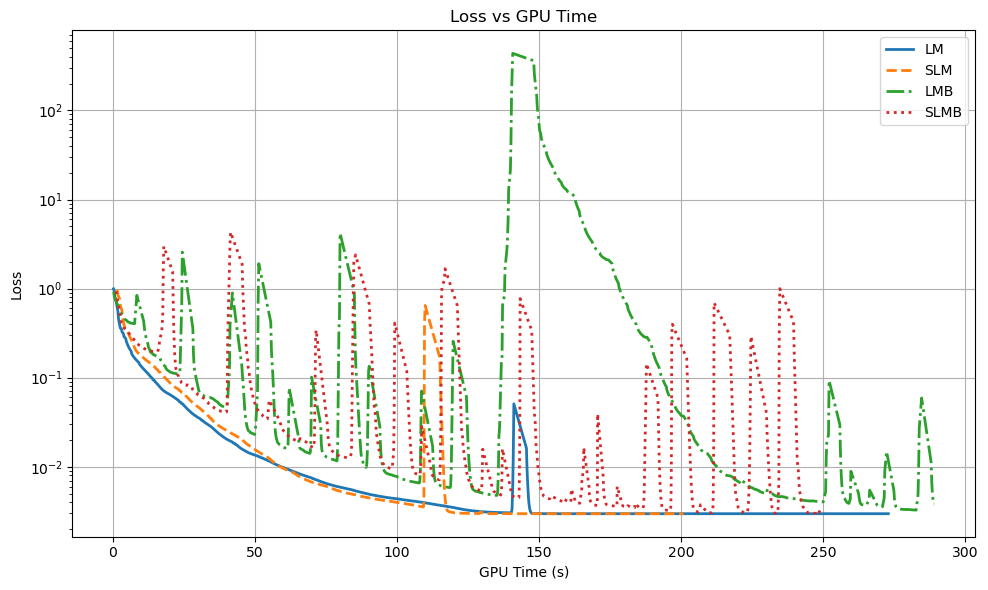

In [ ]:
import torch
import torch.nn as nn
import numpy as np
from functorch import make_functional, vmap, jacrev
# from ucimlrepo import fetch_ucirepo 
import collections
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd


class Network(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size, depth, act=torch.nn.Sigmoid()):
        super(Network, self).__init__()
        layers = []
        layers.append(("layer1", nn.Linear(input_size, hidden_size1)))
        layers.append(("activation1", act))
        if depth >= 2:
            layers.append(("layer2", nn.Linear(hidden_size1, hidden_size2)))
            layers.append(("activation2", act))
            layers.append(("layer3", nn.Linear(hidden_size2, output_size, bias=False)))
        else:
            layers.append(("layer2", nn.Linear(hidden_size1, output_size, bias=False)))
        self.model = nn.Sequential(collections.OrderedDict(layers))
        self.p_number = sum(p.numel() for p in self.model.parameters())

    def forward(self, x):
        return self.model(x)

class PINN_LM:
    def __init__(self, X_data, y_data, cuda_num=6):
        self.device = torch.device(f"cuda:{cuda_num}" if torch.cuda.is_available() else "cpu")
        self.X_data = X_data.to(self.device)
        self.y_data = y_data.to(self.device).view(-1)
        self.data_num = self.X_data.shape[0]
        torch.set_default_dtype(torch.float64)
        self.model = Network(self.X_data.shape[1],70, 70, 1, 2).double().to(self.device)
        self.p_number = self.model.p_number

        print('model # of parameters:', self.p_number)

        self.loss_record = np.zeros(100000)
        self.time_record = np.zeros(100000)
        self.loss_iter = 0
        self.time_iter = 0
        ## Initial weights
        def initialize_weights(self):
            for m in self.modules():
                if isinstance(m, nn.Linear):
                    nn.init.xavier_normal_(m.weight.data)
                    if m.bias is not None:
                        m.bias.data.zero_()
                        # m.bias.data.normal_(mean=0.0, std=1.0)

        initialize_weights(self.model)
        
    

    def f(self, params, input_data):
        a = 0
        for module in self.model.model.children():
            if isinstance(module, nn.Linear):
                in_f = module.weight.size(1)
                out_f = module.weight.size(0)
                w_size = in_f * out_f
                module.weight.data = params[a:a + w_size].reshape(out_f, in_f).clone()
                a += w_size
                if module.bias is not None:
                    module.bias.data = params[a:a + out_f].clone()
                    a += out_f
        return torch.vmap(self.model)(input_data)

    def fx_fun(self, params):
        preds = self.f(params, self.X_data).view(-1)
        return preds - self.y_data

    def F_fun(self, fx):
        return torch.mean(fx**2)

    def J_func(self, params):
        params.requires_grad_(True)
        func_model, func_params = make_functional(self.model)

        def fm(x, fp): return func_model(fp, x).squeeze()
        def floss(fp, x): return fm(x, fp)

        per_sample_grads = vmap(jacrev(floss), (None, 0))(func_params, self.X_data)
        
        cnt=0
                
        for g in per_sample_grads: 
            g = g.detach()
            J_d = g.reshape(len(g),-1) if cnt == 0 else torch.hstack([J_d,g.reshape(len(g),-1)])
            cnt = 1
        
        result= J_d.detach()
        return result

    def broyden_partial_update(self, J_prev, delta_r, delta_theta, indices):
        with torch.no_grad():
            J_sub = J_prev[:, indices]
            correction = torch.outer((delta_r - J_sub @ delta_theta), delta_theta) / (delta_theta.T @ delta_theta)
            J_new = J_prev.clone()
            J_new[:, indices] = J_sub + correction
        return J_new

    def SLM(self, opt_num=200, step=50,bd_tol=0,zone=2/3):
        p = torch.cat([p.view(-1) for p in self.model.parameters()]).to(self.device)
        J = self.J_func(p)
        mu = 10
        lmin, lmax = 1e-16, 1e100
        lambda_up, lambda_down = 2, 0.5
        yi, yi2 = 1e-16, 1e-5
        alpha = 1
        F_pnew = 1
        k, reject = 0, 0
        elapsed_time_ms=0
        selected_cols = np.random.choice(self.p_number, opt_num, replace=False)
        start_event = torch.cuda.Event(enable_timing=True)
        start_event.record()
        while k < step:
            end_event = torch.cuda.Event(enable_timing=True)
            k += 1
            fx = self.fx_fun(p)
            F_p = self.F_fun(fx)
            J_opt = J[:, selected_cols]
            A_opt =torch.matmul(J_opt.t(),J_opt)
            diag = torch.eye(A_opt.shape[0]).to(self.device)
            H = A_opt + mu * diag
            with torch.no_grad():
                    
                    gk=torch.matmul(J.t(),fx)
                    # gkF=torch.matmul(J_opt.t(),fx)
                    gkF=gk[selected_cols]
            try:              
                    h_lm = torch.linalg.solve(H, -gkF)      
                        
            except:
                    print('singular matrix')

            p_new = p.clone()
            p_new[selected_cols] += alpha * h_lm.view(-1)
            fx_new = self.fx_fun(p_new)
            F_pnew = self.F_fun(fx_new)
            o = F_p - F_pnew
            o_=torch.matmul(gkF.t(),h_lm)+1/2*torch.matmul(h_lm.t(),torch.matmul(A_opt,h_lm))+1/2*mu*torch.norm(h_lm, p=2)

            if o / o_ > yi and torch.norm(gkF)**2 > yi2 / mu:
                reject=0
                self.loss_record[self.loss_iter] = float(F_pnew.item())
                self.loss_iter += 1
                self.time_record[self.time_iter] = elapsed_time_ms/1000
                self.time_iter += 1
                print(f"[{k}] Accept | Loss = {F_p.item():.6f} -> {F_pnew.item():.6f} | parameter #: {opt_num}| time: {elapsed_time_ms}")
                p = p_new
                if reject >= bd_tol:
                    J = self.J_func(p)
                else:
                    J = self.broyden_partial_update(J, fx_new - fx, h_lm.view(-1), selected_cols)
                mu = max(mu * lambda_down, lmin)
                if k%5==0:
                    rho=1/(2*torch.norm(gk,p=2)**4 * mu**2)
                    if rho <=1 :
                        opt_num=int(np.round(self.p_number*torch.sqrt(1-rho).item()))
                        print("optnumber",opt_num)
                        #torch.sqrt(1-1/(2*torch.norm(gk,p=2)**4 * mu**2))
                    else:
                        print('zone')
                        opt_num=int(np.round(zone*self.p_number))
                        
                    selected_cols = np.random.choice(self.p_number, opt_num, replace=False)

            else:
                if reject >= bd_tol:
                    J = self.J_func(p)
                print(f"[{k}] Reject")
                reject += 1
                
                
                mu = min(mu * lambda_up, lmax)
                
            end_event.record()
            torch.cuda.synchronize()  # Wait for the events to be recorded!
            elapsed_time_ms = start_event.elapsed_time(end_event)
        
        self.time_record[self.time_iter] = elapsed_time_ms/1000
        self.loss_record[self.loss_iter] = float(F_pnew.item())
        print(f"Training finished. Final loss:{F_pnew.item()}, average time: {elapsed_time_ms/(1000*step)}")
        
        
        
        
        
        
        
        
    def LM(self, opt_num=200, step=50,bd_tol=0):
        p = torch.cat([p.view(-1) for p in self.model.parameters()]).to(self.device)
        J = self.J_func(p)
        mu = 1000
        lmin, lmax = 1e-16, 1e100
        lambda_up, lambda_down = 2, 0.5
        yi, yi2 = 1e-16, 1e-5
        alpha = 1
        F_pnew = 1
        k, reject = 0, 0
        elapsed_time_ms=0
        selected_cols = np.random.choice(self.p_number, opt_num, replace=False)
        start_event = torch.cuda.Event(enable_timing=True)
        start_event.record()
        while k < step:
            end_event = torch.cuda.Event(enable_timing=True)
            k += 1
            fx = self.fx_fun(p)
            F_p = self.F_fun(fx)
            J_opt = J[:, selected_cols]
            A_opt =torch.matmul(J_opt.t(),J_opt)
            diag = torch.eye(A_opt.shape[0]).to(self.device)
            H = A_opt + mu * diag
            with torch.no_grad():
                    # gkF=torch.matmul(J_opt.t(),fx)
                    
                    gk=torch.matmul(J.t(),fx)
                    gkF=gk[selected_cols]
            try:              
                    h_lm = torch.linalg.solve(H, -gkF)      
                        
            except:
                    print('singular matrix')

            p_new = p.clone()
            p_new[selected_cols] += alpha * h_lm.view(-1)
            fx_new = self.fx_fun(p_new)
            F_pnew = self.F_fun(fx_new)
            o = F_p - F_pnew
            o_=torch.matmul(gkF.t(),h_lm)+1/2*torch.matmul(h_lm.t(),torch.matmul(A_opt,h_lm))+1/2*mu*torch.norm(h_lm, p=2)

            if o / o_ > yi and torch.norm(gkF)**2 > yi2 / mu:
                reject=0
                self.loss_record[self.loss_iter] = float(F_pnew.item())
                self.loss_iter += 1
                self.time_record[self.time_iter] = elapsed_time_ms/1000
                self.time_iter += 1
                print(f"[{k}] Accept | Loss = {F_p.item():.6f} -> {F_pnew.item():.6f} | parameter #: {opt_num}| time: {elapsed_time_ms}")
                p = p_new
                if reject >= bd_tol:
                    J = self.J_func(p)
                else:
                    J = self.broyden_partial_update(J, fx_new - fx, h_lm.view(-1), selected_cols)
                mu = max(mu * lambda_down, lmin)
                
            else:
                if reject >= bd_tol:
                    J = self.J_func(p)
                print(f"[{k}] Reject")
                reject += 1
                
                mu = min(mu * lambda_up, lmax)
            end_event.record()
            torch.cuda.synchronize()  # Wait for the events to be recorded!
            elapsed_time_ms = start_event.elapsed_time(end_event)
        self.time_record[self.time_iter] = elapsed_time_ms/1000
        self.loss_record[self.loss_iter] = float(F_pnew.item())

        print(f"Training finished. Final loss:{F_pnew.item()}, average time: {elapsed_time_ms/(1000*step)}")

def plot_loss_vs_time(loss1, time1, loss2, time2,loss3,time3,loss4,time4, label1="LM", label2="SLM",label3="LMB",label4="SLMB"):
        loss1 = loss1[time1 != 0]
        time1 = time1[time1 != 0]
        loss2 = loss2[time2 != 0]
        time2 = time2[time2 != 0]
        loss3 = loss3[time3!= 0]
        time3 = time3[time3 != 0]
        loss4 = loss4[time4 != 0]
        time4 = time4[time4 != 0]

        plt.figure(figsize=(10, 6))
        plt.plot(time1, loss1, label=label1, linestyle='-',  color='#1f77b4', linewidth=2)  # muted blue
        plt.plot(time2, loss2, label=label2, linestyle='--', color='#ff7f0e', linewidth=2)  # muted orange
        plt.plot(time3, loss3, label=label3, linestyle='-.', color='#2ca02c', linewidth=2)  # muted green
        plt.plot(time4, loss4, label=label4, linestyle=':',  color='#d62728', linewidth=2)  # muted red
                

        plt.xlabel("GPU Time (s)")
        plt.ylabel("Loss")
        plt.title("Loss vs GPU Time")
        plt.yscale("log")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
# === 训练入口 ===
if __name__ == "__main__":

    # 读取 Excel 文件
    df = pd.read_excel("/home/zhy/Zhou/lm/Ccs/Concrete_Data.xls")

    # 显示列名（确认目标列是哪一个）
    # print(df.columns)

    # 假设最后一列是目标变量（Strength）
    X = df.iloc[:, :-1]  # 所有列（除最后一列）为特征
    y = df.iloc[:, -1]   # 最后一列为目标

    scaler_X = StandardScaler()
    scaler_y = StandardScaler()

    X_scaled = scaler_X.fit_transform(X)
    y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))
    print(y_scaled)

    
    # X_tensor = torch.tensor(X.values, dtype=torch.float64)
    # y_tensor = torch.tensor(y.values.reshape(-1, 1), dtype=torch.float64)
    X_tensor = torch.tensor(X_scaled, dtype=torch.float64)
    y_tensor = torch.tensor(y_scaled, dtype=torch.float64)
    print(X_tensor.shape)

    # 训练 LM
    model_lm = PINN_LM(X_tensor, y_tensor)
    model_lm.LM(opt_num=5670, step=1400,bd_tol=0)

    # 训练 MLM
    model_slm = PINN_LM(X_tensor, y_tensor)
    model_slm.SLM(opt_num=5670, step=1400,bd_tol=0,zone=2/3)
    
    
    model_slmb = PINN_LM(X_tensor, y_tensor)
    model_slmb.SLM(opt_num=5670, step=1400,bd_tol=1,zone=2/3)
    
    model_lmb = PINN_LM(X_tensor, y_tensor)
    model_lmb.LM(opt_num=5670, step=1400,bd_tol=1)
    
    # 绘图对比
    plot_loss_vs_time(
        model_lm.loss_record, model_lm.time_record,
        model_slm.loss_record, model_slm.time_record,
        model_lmb.loss_record, model_lmb.time_record,
        model_slmb.loss_record, model_slmb.time_record,
    )